In [1]:
library(tidyverse)
library(umap)
library(ggsci)

library(limma)
library(edgeR)
# add deseq2
library(DESeq2)


Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────


## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)
- PRJEB10878 (CHINA)

# Plots

In [2]:
pca_plot <- function(df, batch_info, title, path = "", color_column = "condition", shape_column = "lab") {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample") %>% 
    left_join(batch_info,  by = "sample") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes_string("PC1", "PC2", color = color_column)) +
    geom_point(aes_string(col=color_column, shape=shape_column), size=2) +
    stat_ellipse(type = "t", level = 0.95) + # Add ellipses for each condition+
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]")) 


  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot)
  }
}


# boxplot
boxplot_plot <- function(protein_matrix, title, path = "") {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "sample", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = sample, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 1.5, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 5)) +
    labs(title = title) 

  if (path == "") {
    return(boxplot)
  } else {
    ggsave(path, boxplot)
  }
}



umap_plot <- function(df, metadata, title = "UMAP Projection", color_column = "study_accession", path = "") {
  # Perform UMAP on the transposed merged mass spectrometry data
  umap_result <- umap(t(df))
  
  # Convert the UMAP result into a data frame and merge with metadata
  umap_data <- data.frame(umap_result$layout) %>%
    rownames_to_column('sample') %>%
    # rename(sample = rowname) %>%
    left_join(metadata[, c('sample', 'country', 'class', 'study_accession', 'instrument_model', 'Study_Equip')], by = "sample") %>%
    column_to_rownames("sample")
   

  plot <- ggplot(umap_data, aes_string(x = "X1", y = "X2", color = color_column)) +
    geom_point(aes_string(col = color_column), size = 0.7) +
    stat_ellipse(type = "t", level = 0.95) + # Add ellipses for each condition
    theme_minimal() +
    scale_color_lancet() + 
    labs(title = title, x = "UMAP 1", y = "UMAP 2") +
    guides(color = guide_legend(override.aes = list(size = 3))) # Ensure legend accurately represents centroids
  
    
    if (path == "") {
        return(plot)
  } else {
        ggsave(path, plot)
  }
}


# Read data

In [3]:
metadata <- read.csv('/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/metadata_2250_CRC_cohort_20231114.tsv', sep = '\t') %>%
    filter(is.na(to_exclude)) %>%
    filter(class != "adenoma") %>%
    mutate(class = as.factor(class), country = as.factor(country)) %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878", "PRJNA429097")) %>%
    filter(!(study_accession == "PRJEB6070" & country == "DEU")) %>% 
    mutate(Study_Equip = paste(study_accession, instrument_model, sep = "_")) %>%
    mutate(Study_Equip = as.factor(Study_Equip), gender = as.factor(gender))
dim(metadata)
head(metadata)

[1] 489  35

sample     HQ_clean_read_count gut_mapped_read_count gut_mapped_pc
1 SRS2821229 33149876            24527825              73.99070     
2 SRS2821228 31521340            25656324              81.39351     
3 SRS2821227 38953502            34039345              87.38456     
4 SRS2821226 39822130            33152273              83.25088     
5 SRS2821225 40534780            32379342              79.88039     
6 SRS2821224 36754902            31519949              85.75713     
  oral_mapped_read_count oral_mapped_pc MGS low_read low_map excluded ⋯
1 24527825               73.99070       287 NA       NA      NA       ⋯
2 25656324               81.39351       111 NA       NA      NA       ⋯
3 34039345               87.38456       255 NA       NA      NA       ⋯
4 33152273               83.25088       437 NA       NA      NA       ⋯
5 32379342               79.88039       288 NA       NA      NA       ⋯
6 31519949               85.75713       312 NA       NA      NA       ⋯
  body_subsite health_status host_phenotype host_subphenotype gender age bmi  
1 stool        H             NA             NA                male   48  22.68
2 stool        H             NA             NA                male   51  23.23
3 stool        H             NA             NA                female 29  23.73
4 stool        H             NA             NA                female 49  22.19
5 stool        H             NA             NA                male   60  23.53
6 stool        H             NA             NA                female 48  23.21
  class   to_exclude Study_Equip            
1 healthy NA         PRJNA429097_HiSeq X Ten
2 healthy NA         PRJNA429097_HiSeq X Ten
3 healthy NA         PRJNA429097_HiSeq X Ten
4 healthy NA         PRJNA429097_HiSeq X Ten
5 healthy NA         PRJNA429097_HiSeq X Ten
6 healthy NA         PRJNA429097_HiSeq X Ten

In [44]:
rownames_msp <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/species_signal_2250_CRC_cohort_20231115.tsv", sep = "\t")$msp_id

msp_counts <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/species_signal_count_table_2250_CRC_cohort_20240123.tsv", sep = "\t")
rownames(msp_counts) <- rownames_msp
msp_counts <- msp_counts[, colnames(msp_counts) %in% metadata$sample]

dim(msp_counts)
head(msp_counts)


[1] 2537  489

ERS848618 ERS848619 ERS848620 ERS848621 ERS848622 ERS848629 ERS848630
msp_0001     0        0         0         0        0         0           0    
msp_0002     0        0         0         0        0         0           0    
msp_0003   495     1207        10      1223      478       347        2994    
msp_0004     0        0         0         0        0         0           0    
msp_0005 64027      676      2274      3606      750       680       14436    
msp_0006     0        0         0         0        0         0           0    
         ERS848631 ERS848633 ERS848635 ⋯ SRS2820941 SRS2820940 SRS2820938
msp_0001    0        0            0    ⋯   0           0          0      
msp_0002    0        0            0    ⋯   0           0          0      
msp_0003   13      110         4907    ⋯ 515           0        745      
msp_0004    0        0            0    ⋯   0           0          0      
msp_0005 2861      707       116001    ⋯ 306        3923       2009      
msp_0006    0        0            0    ⋯   0           0          0      
         SRS2820935 SRS2820928 SRS2821228 SRS2821220 SRS2821219 SRS2821216
msp_0001 1103           0           0        0          0          0      
msp_0002    0           0           0        0          0          0      
msp_0003  594        1772        1309       21          0          0      
msp_0004    0           0           0        0          0          0      
msp_0005 7320       29255      102121     4666       4095       3792      
msp_0006    0           0           0        0          0          0      
         SRS2821217
msp_0001 809       
msp_0002   0       
msp_0003 252       
msp_0004   0       
msp_0005 293       
msp_0006   0

In [45]:
logmin_merged_msp <- log2(msp_counts + min(msp_counts[msp_counts > 0])/2)
dim(logmin_merged_msp)

[1] 2537  489

In [47]:
write.table(logmin_merged_msp, file = "/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/before/logmin_four_centers.tsv", sep = "\t")
write.table(metadata, file = "/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/before/metadata_four_centers.tsv", sep = "\t", row.names = FALSE)

## filter

In [5]:
more_then_n <- 1

msp_to_keep <- msp_counts %>%
    t() %>% as.data.frame() %>%
    rownames_to_column("sample") %>%
    left_join(select(metadata, c('sample', 'study_accession')), by = "sample") %>%
    column_to_rownames("sample") %>%
    group_by(study_accession) %>%
    summarise(across(everything(), ~sum(.x != 0))) %>%
    column_to_rownames("study_accession") %>%
    # transpose and convert to data frame 
    t() %>% as.data.frame() %>%
    mutate(keep = ifelse(PRJEB27928 > more_then_n & PRJEB6070 > more_then_n & PRJEB10878 > more_then_n & PRJNA429097 > more_then_n, 1, 0)) %>%
    filter(keep == 1) %>%
    rownames_to_column("msp") %>%
    .[,'msp']

dim(msp_counts)
filtered_msp_counts <- msp_counts[rownames_msp %in% msp_to_keep, ]
dim(filtered_msp_counts)



[1] 2537  525

[1] 892 525

In [6]:

sum(msp_counts == 0) / (nrow(msp_counts) * ncol(msp_counts))
sum(filtered_msp_counts == 0) / (nrow(filtered_msp_counts) * ncol(filtered_msp_counts))

[1] 0.8820827

[1] 0.7060666

## check data

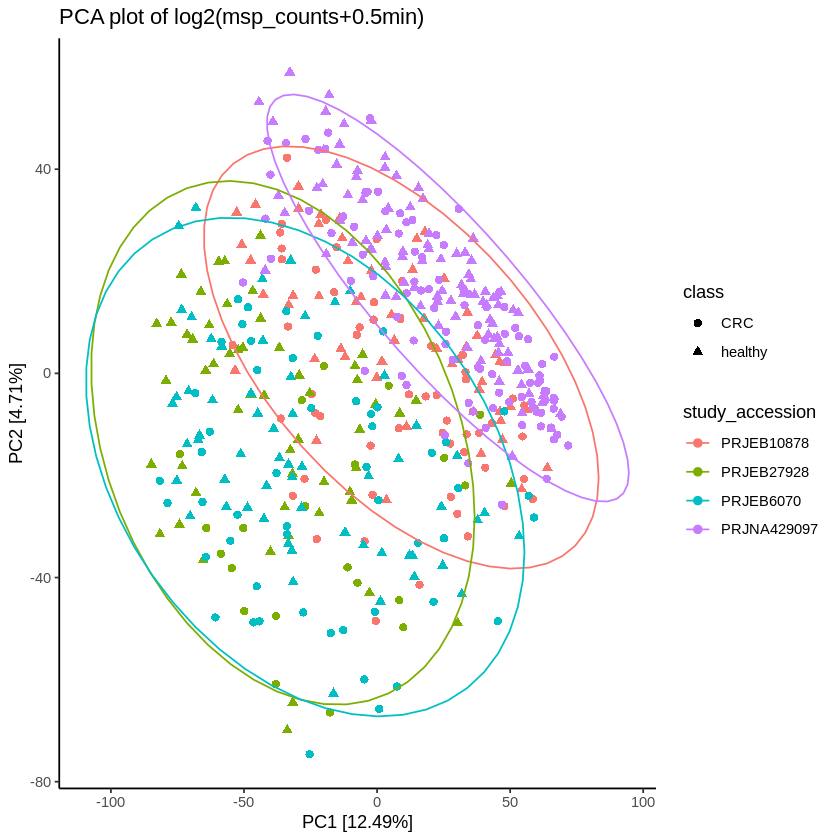

In [17]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")

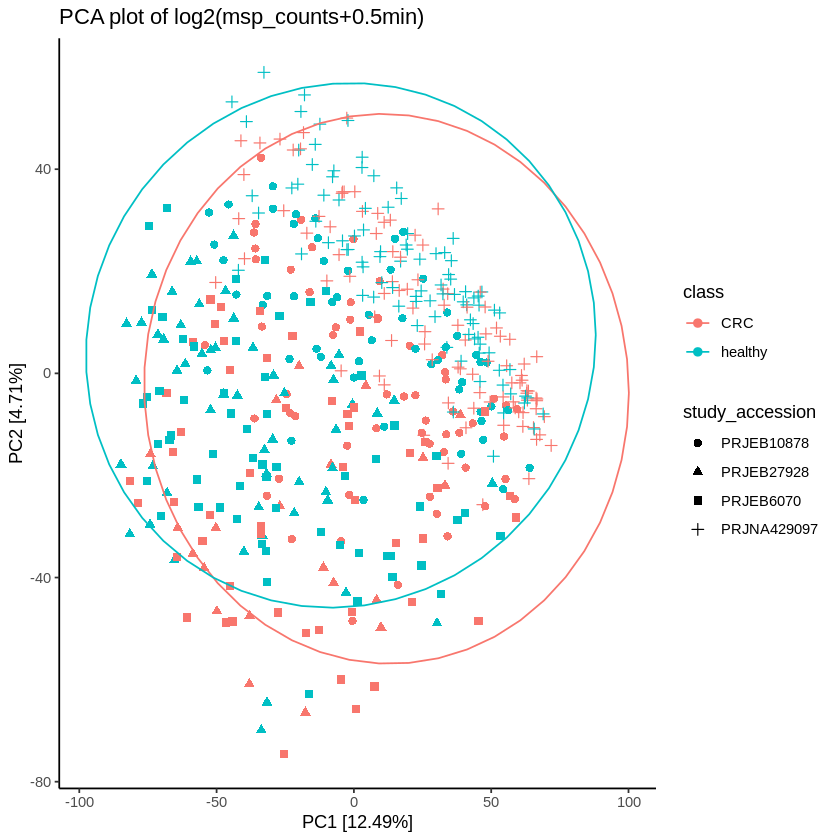

In [19]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

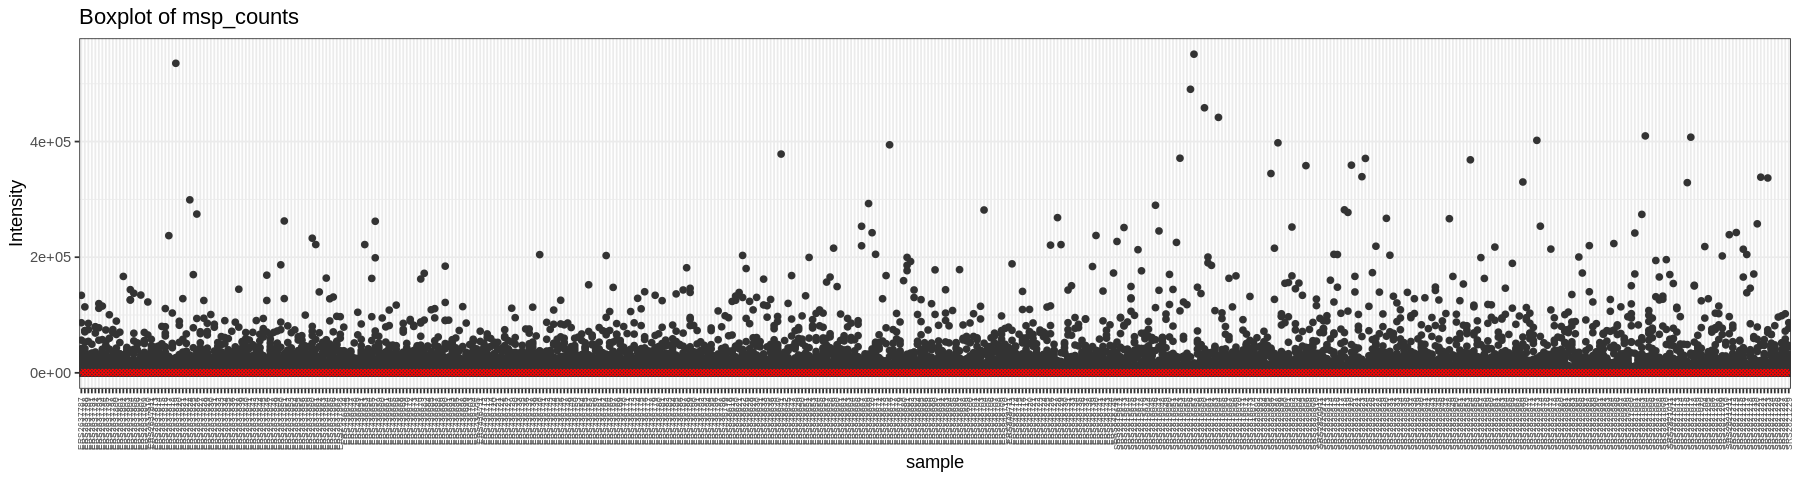

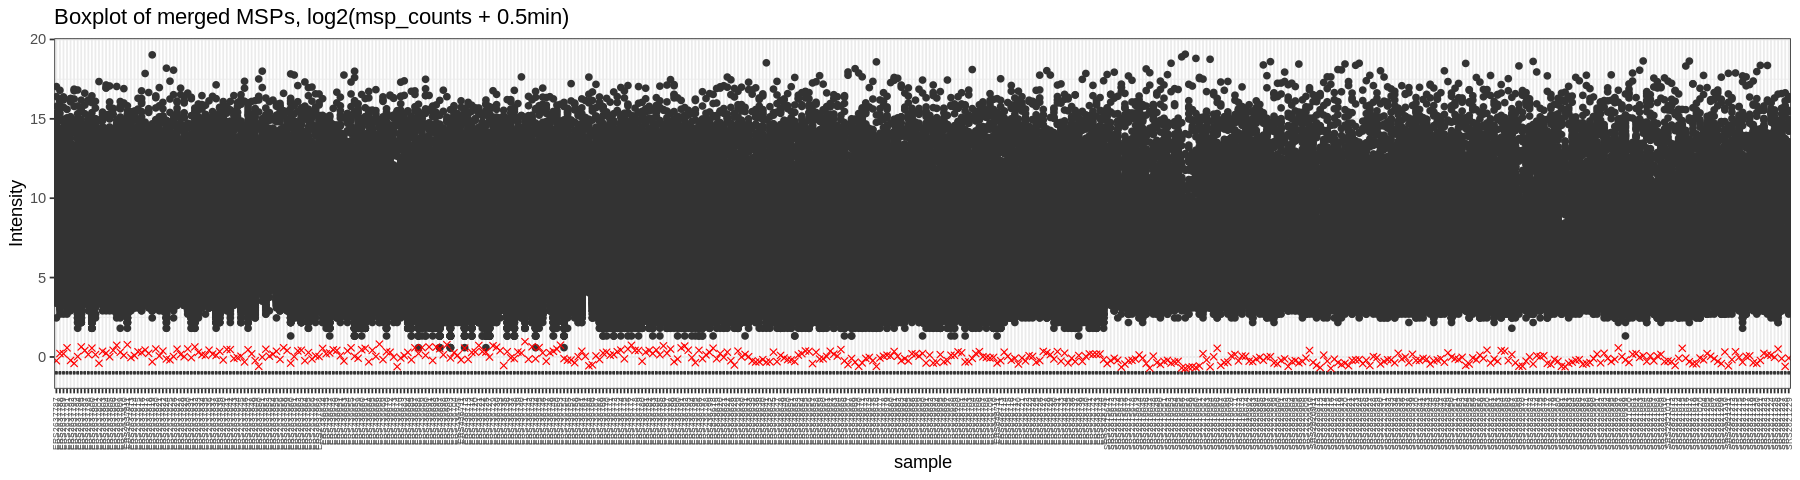

In [20]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(msp_counts, title = "Boxplot of msp_counts")
boxplot_plot(logmin_merged_msp, title = "Boxplot of merged MSPs, log2(msp_counts + 0.5min)")

[1] 2004  193
[1] 2019  146


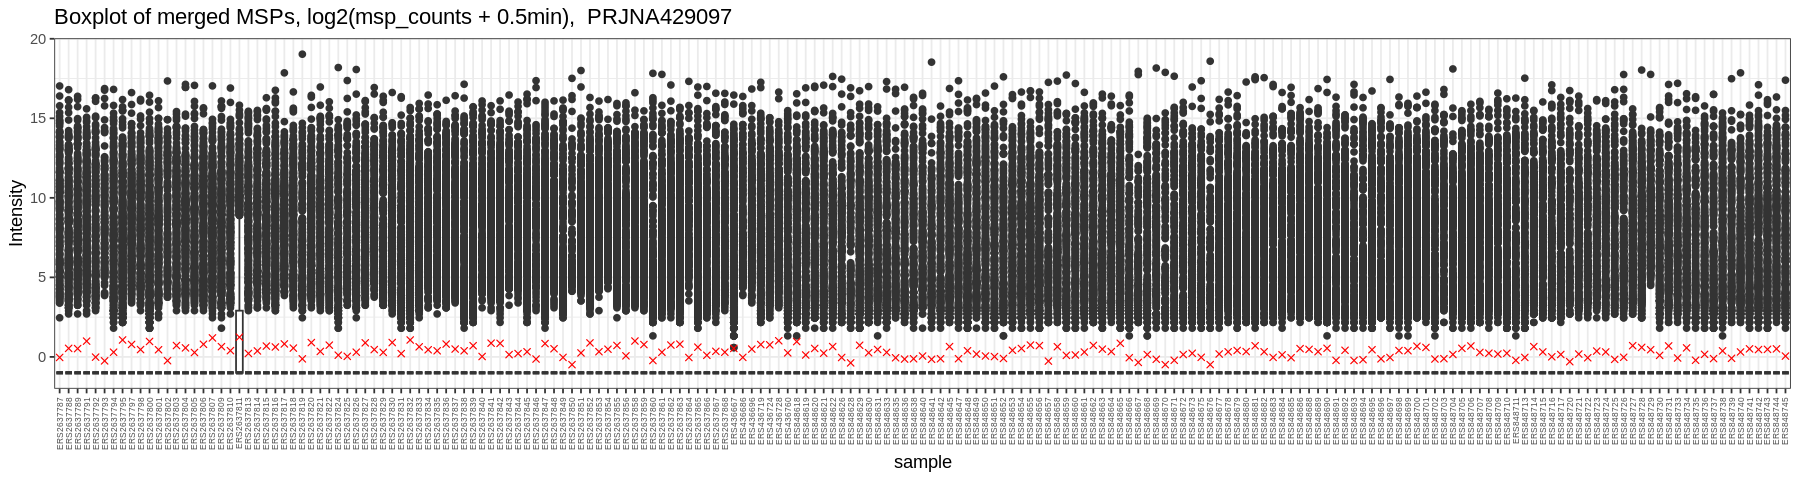

[1] 1374   75


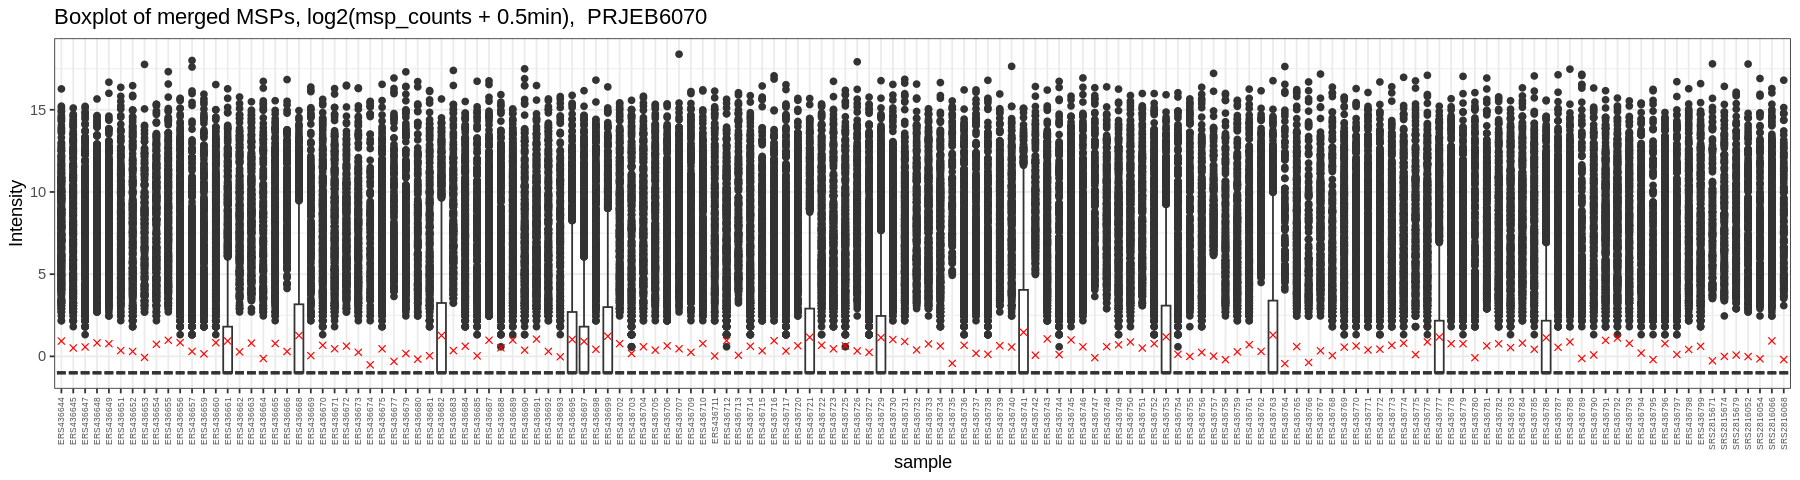

[1] 1541  111


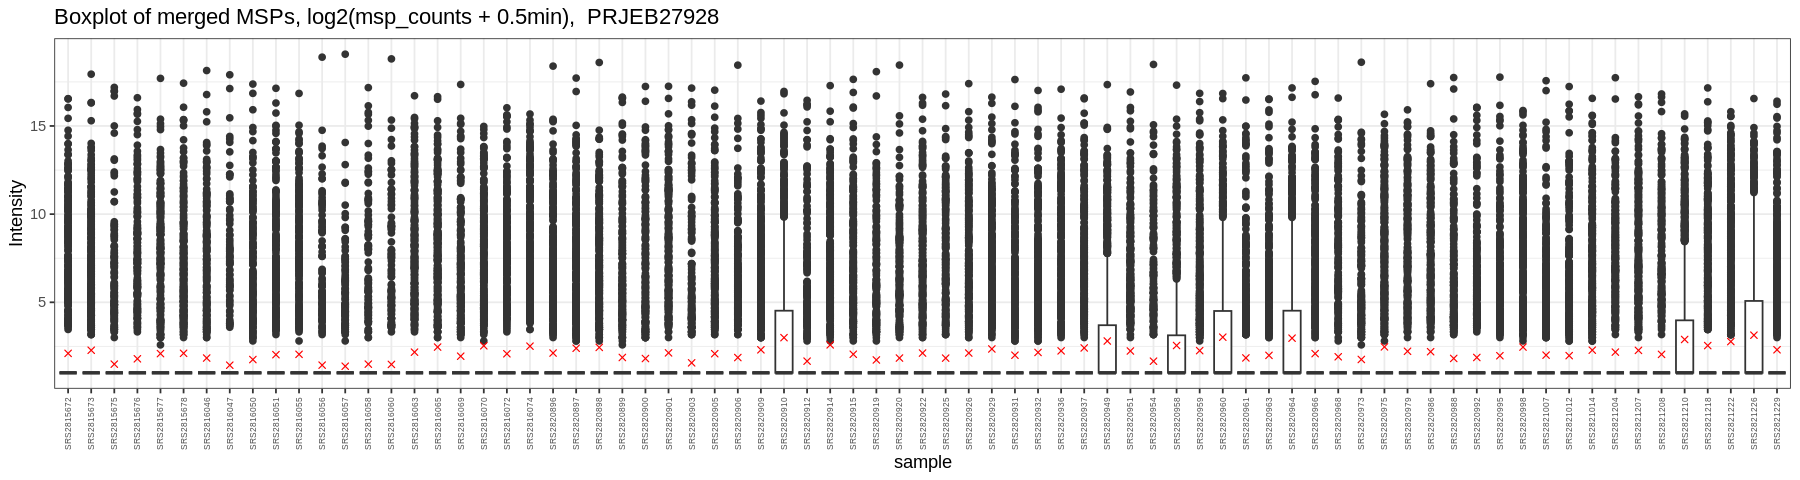

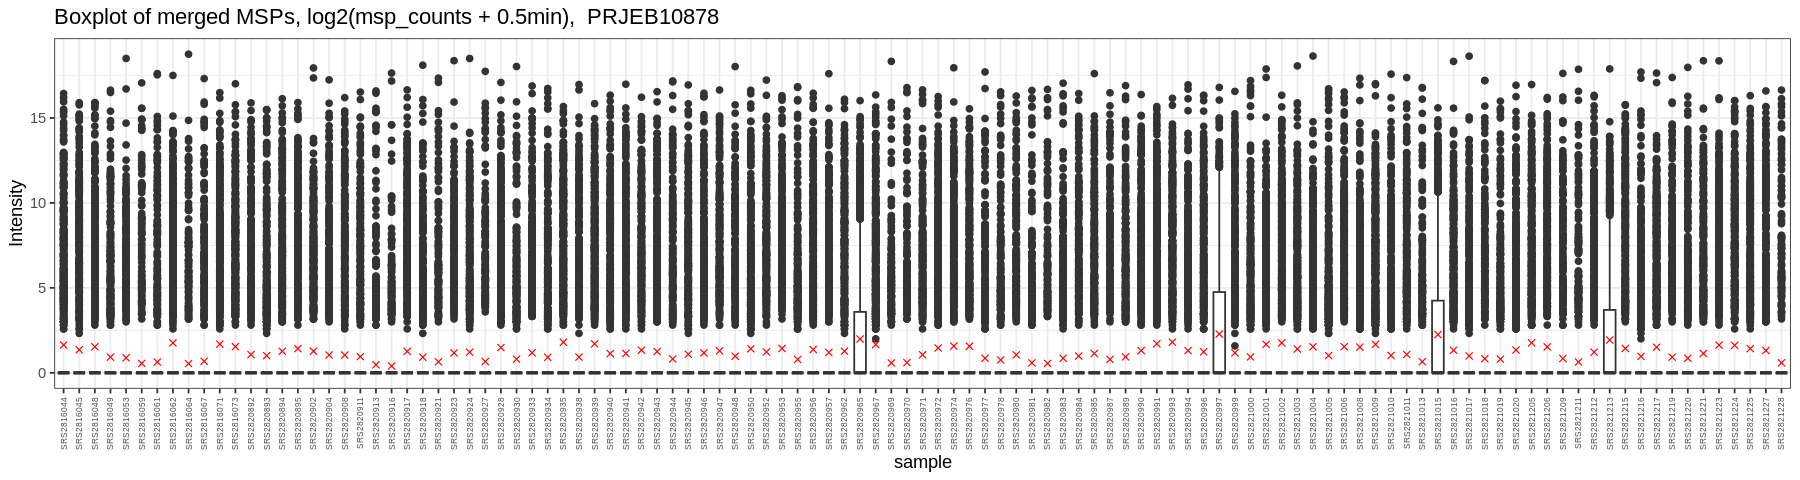

In [14]:
# one boxplot for each study
options(repr.plot.width = 15, repr.plot.height = 4)
for(study in unique(metadata$study_accession)) {
    # get data for plot and remove rows with only zeros
    tmp_plot <- msp_counts[, metadata$study_accession == study]    
    tmp_plot <- tmp_plot[apply(tmp_plot, 1, function(x) !all(x == 0)), ]
    tmp_plot <- log2(tmp_plot + min(tmp_plot[tmp_plot > 0])/2)
    print(dim(tmp_plot))
    plot <- boxplot_plot(tmp_plot, title = paste("Boxplot of merged MSPs, log2(msp_counts + 0.5min), ", study))
    print(plot)
}

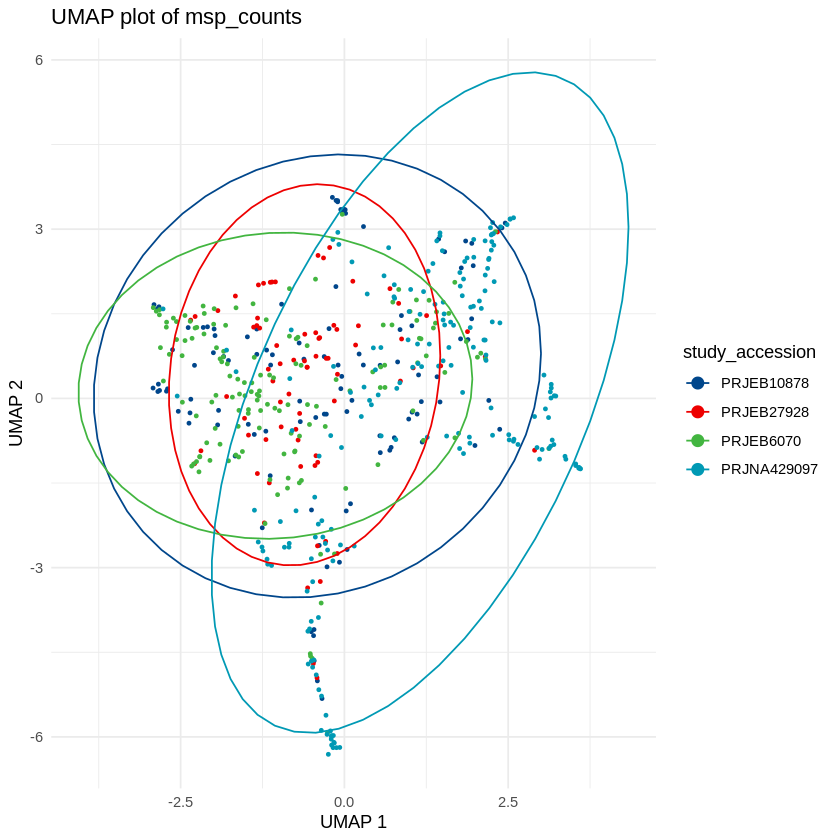

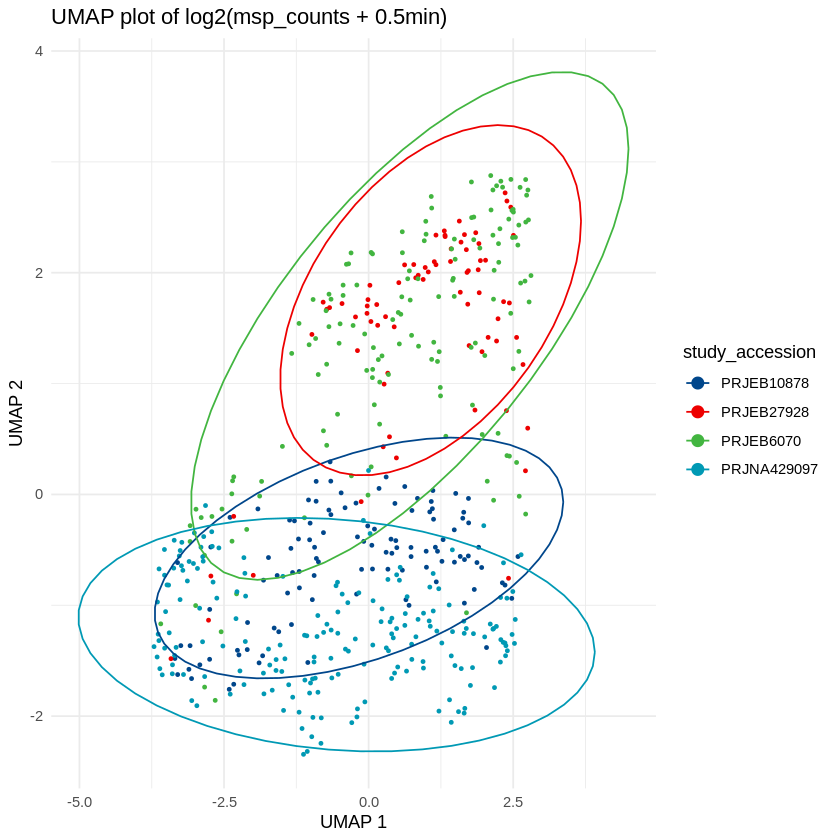

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(msp_counts, metadata, title = "UMAP plot of msp_counts", color_column = "study_accession")
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "study_accession")

### filtered

In [47]:
logmin_filtered_msp <- log2(filtered_msp_counts + min(filtered_msp_counts[filtered_msp_counts > 0])/2)

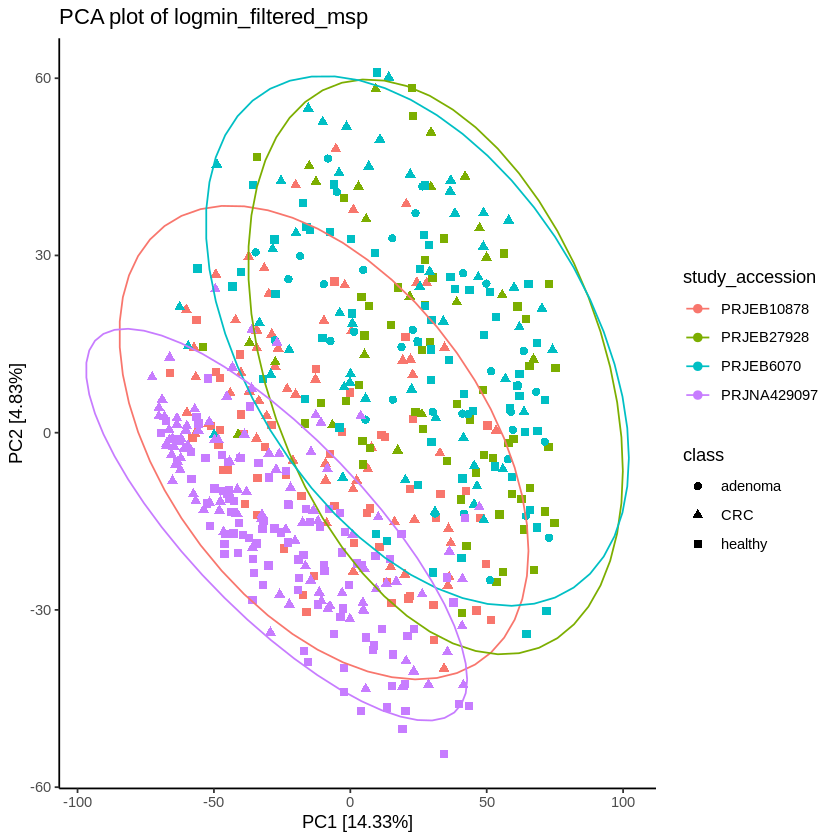

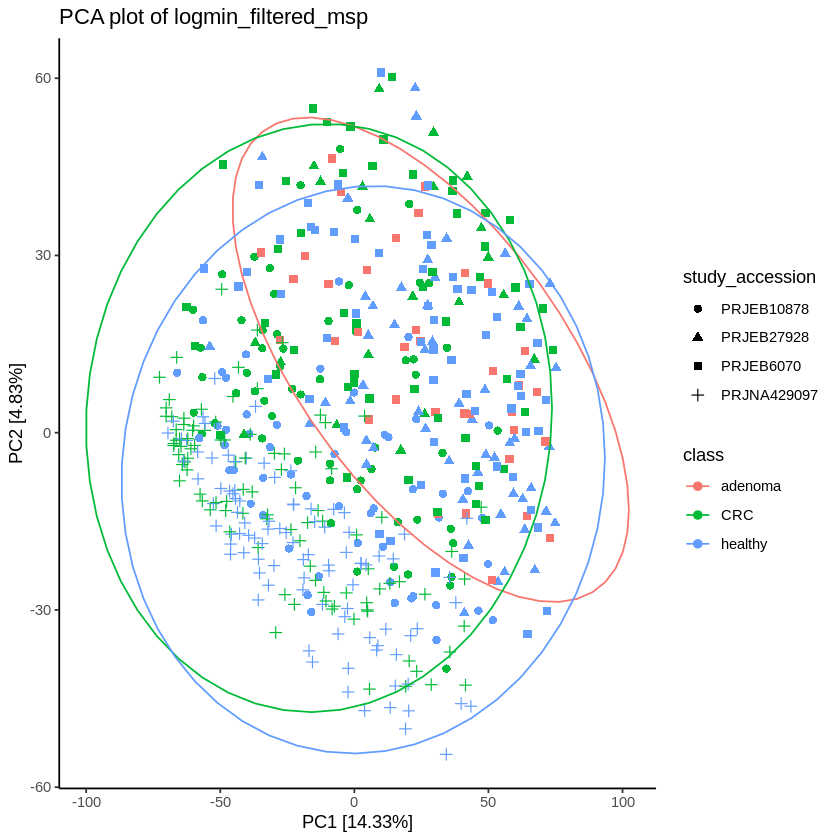

In [48]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(logmin_filtered_msp, metadata, 
        title = "PCA plot of logmin_filtered_msp", 
        color_column = "study_accession", shape_column = "class")

pca_plot(logmin_filtered_msp, metadata, 
        title = "PCA plot of logmin_filtered_msp", 
        shape_column = "study_accession", color_column = "class")

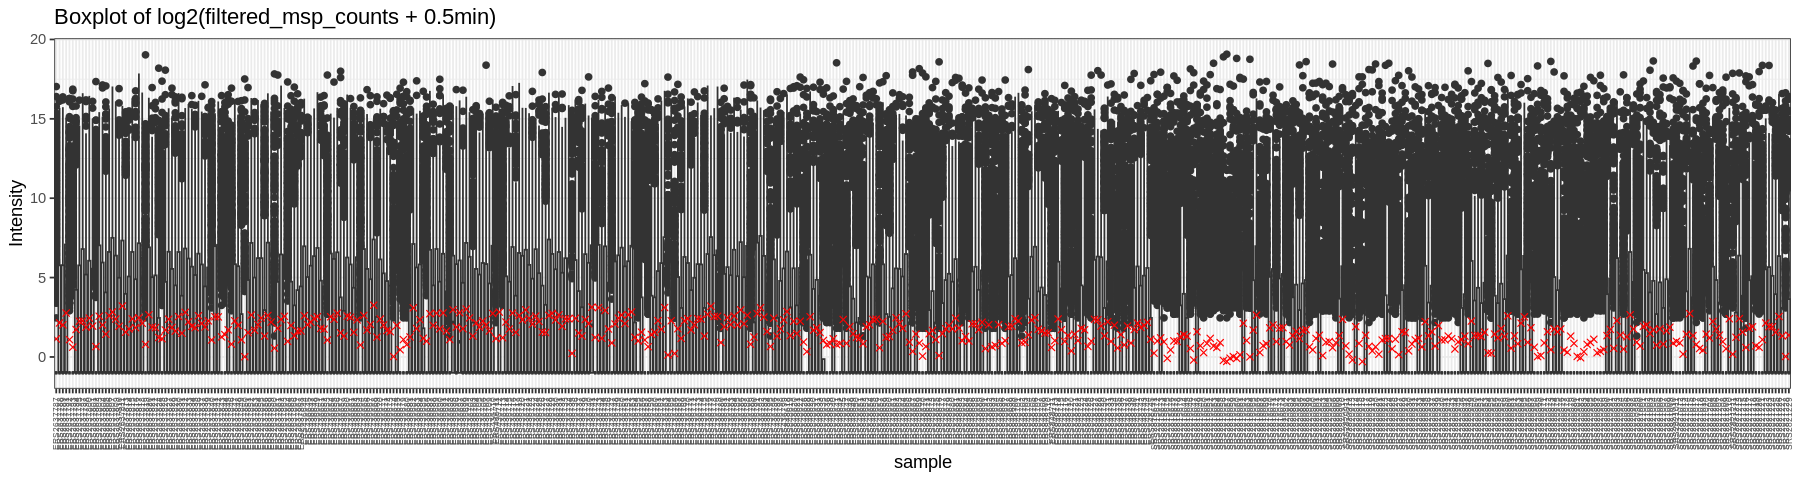

In [49]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(logmin_filtered_msp, title = "Boxplot of log2(filtered_msp_counts + 0.5min)")

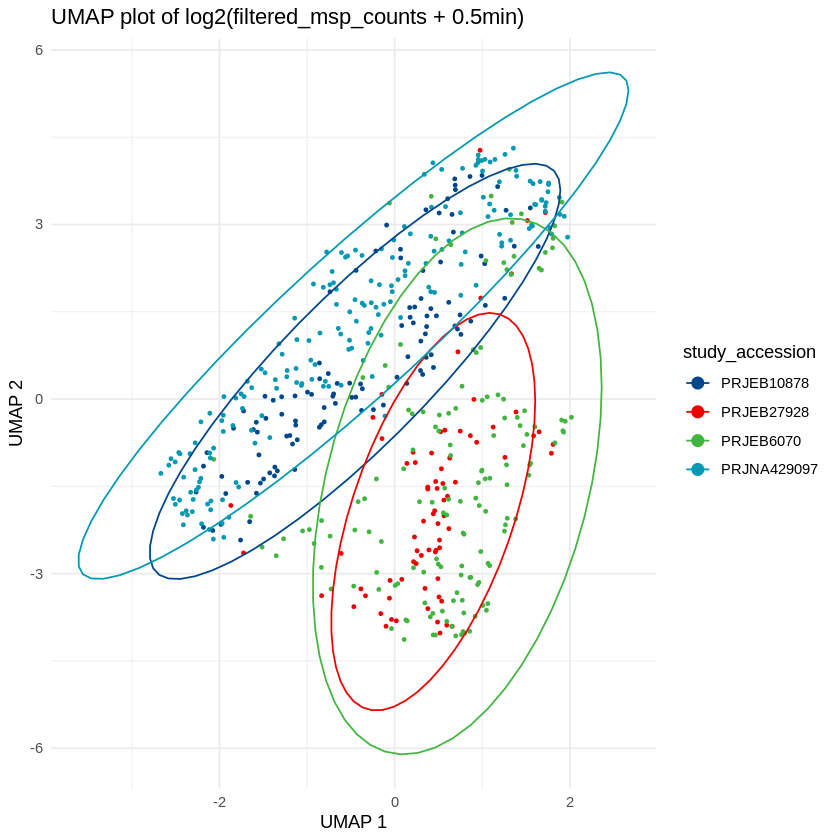

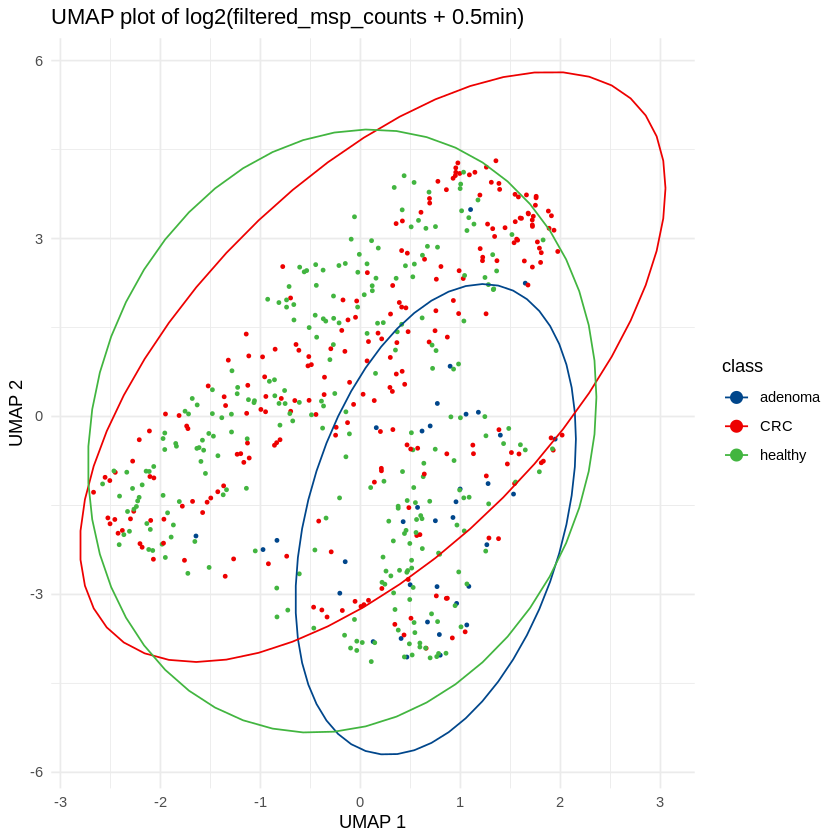

In [50]:
options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")

umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of log2(filtered_msp_counts + 0.5min)", color_column = "class")

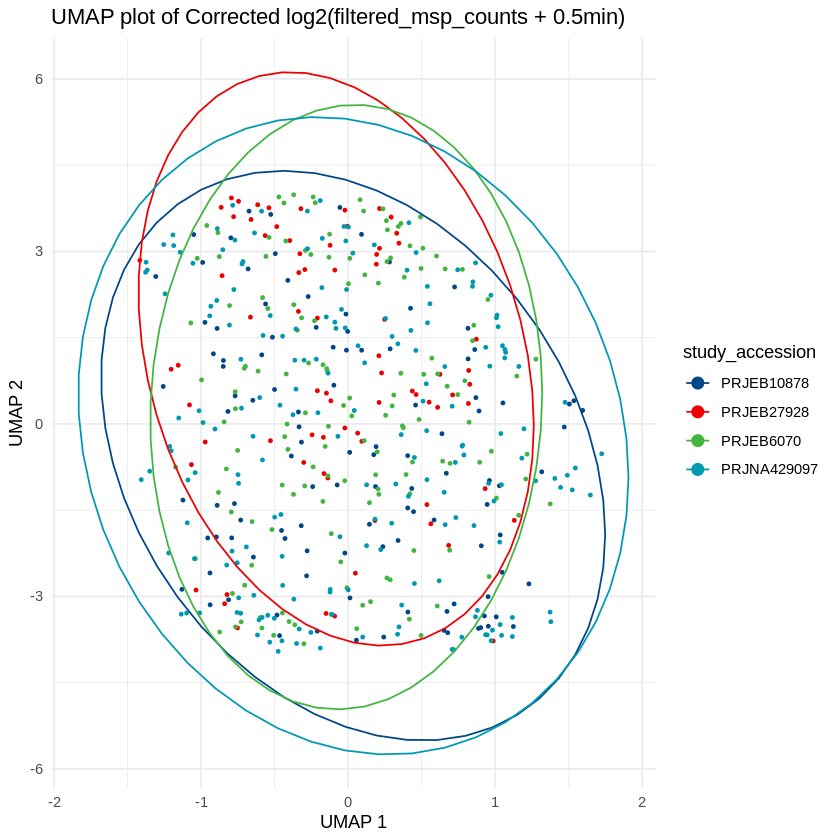

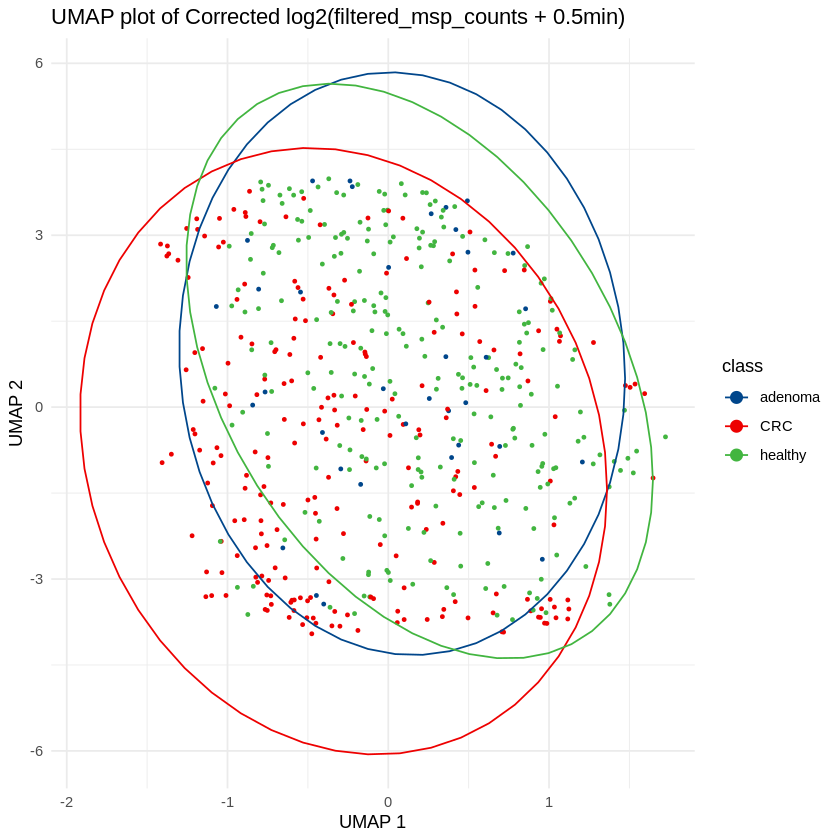

In [52]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_filtered_msp, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(filtered_msp_counts + 0.5min)", color_column = "class")

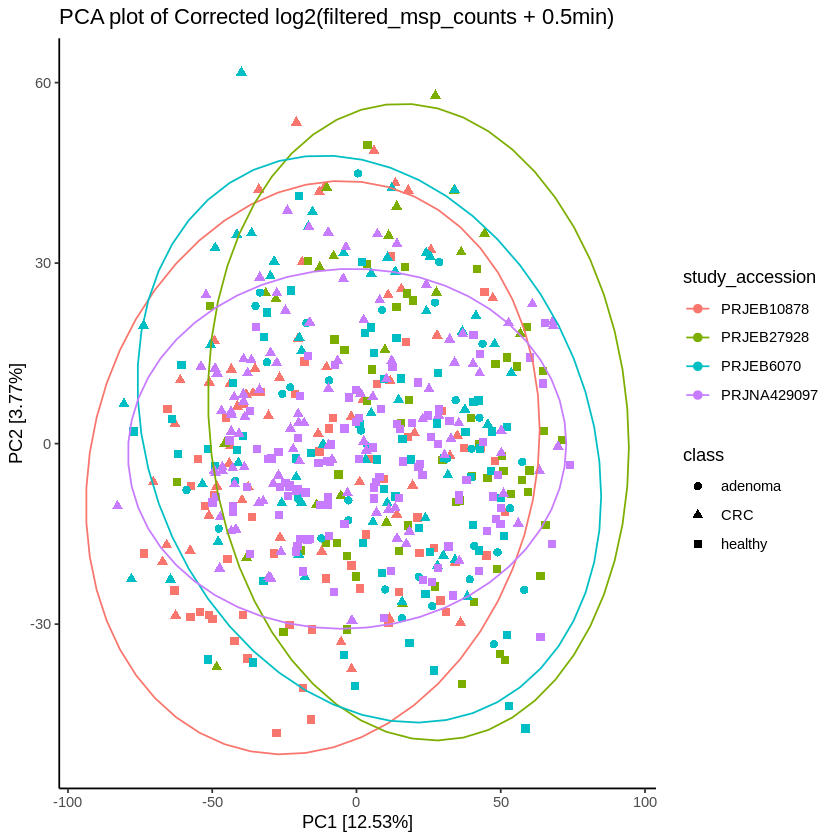

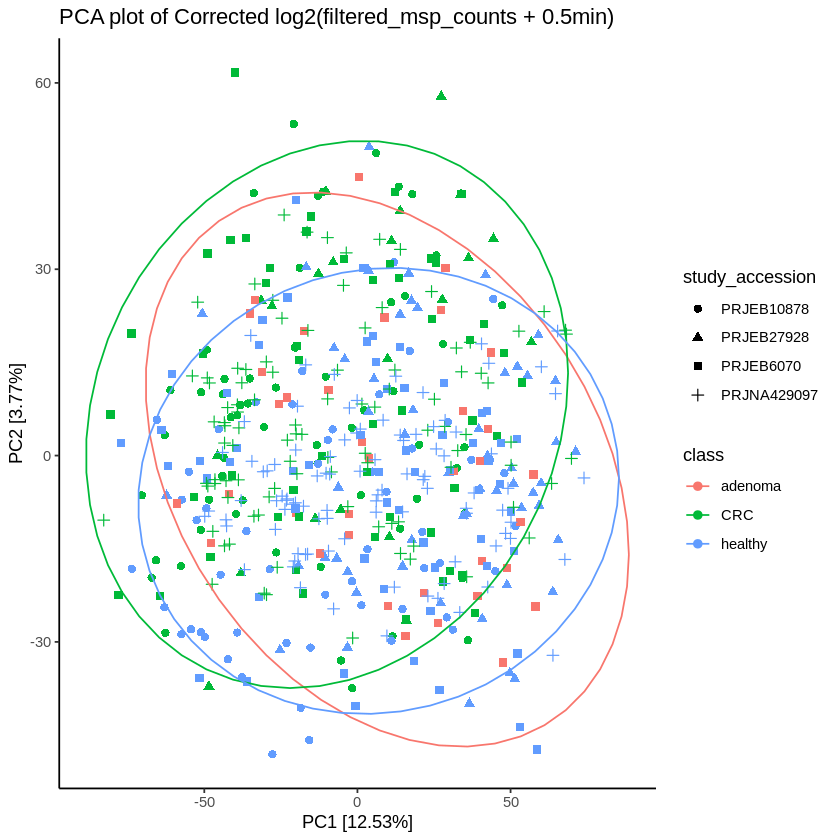

In [53]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(filtered_msp_counts + 0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(filtered_msp_counts + 0.5min)", 
        shape_column = "study_accession", color_column = "class")

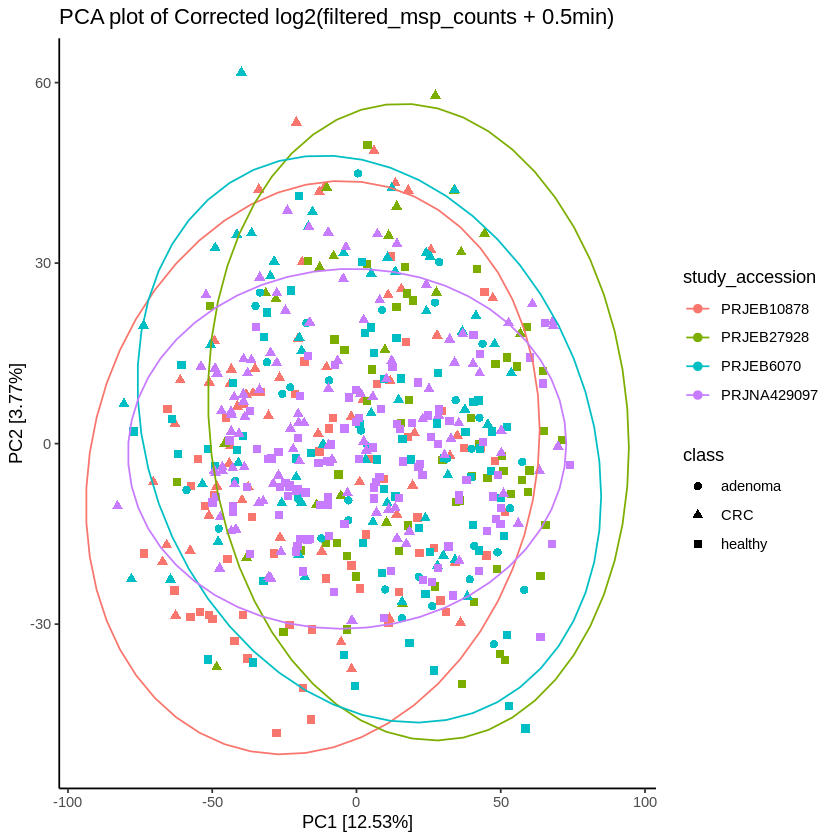

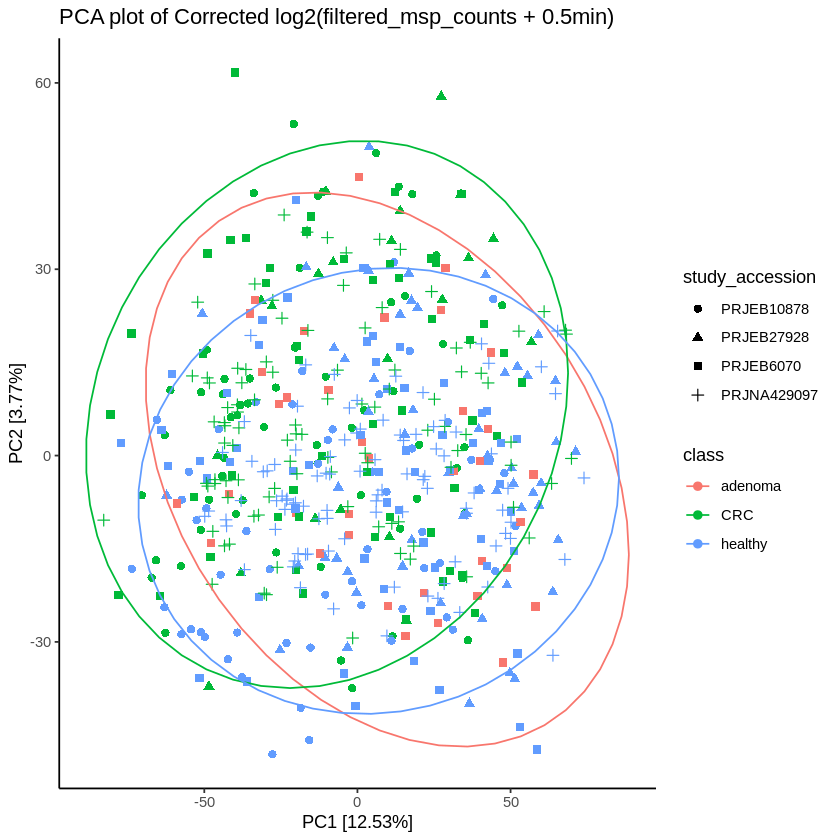

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(filtered_msp_counts + 0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(filtered_msp_counts + 0.5min)", 
        shape_column = "study_accession", color_column = "class")

## Correction

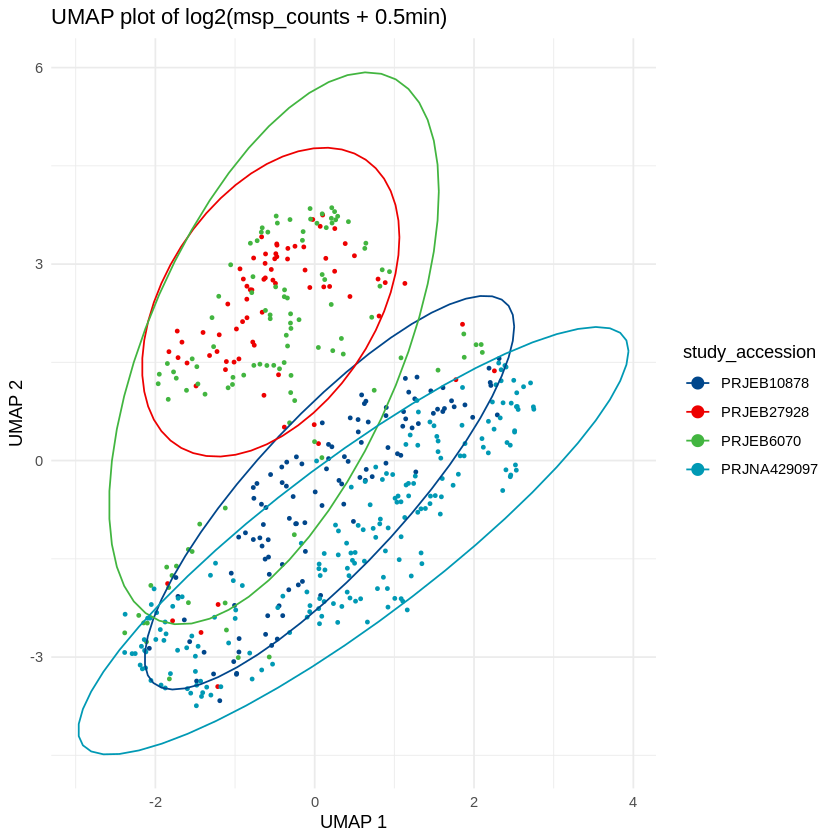

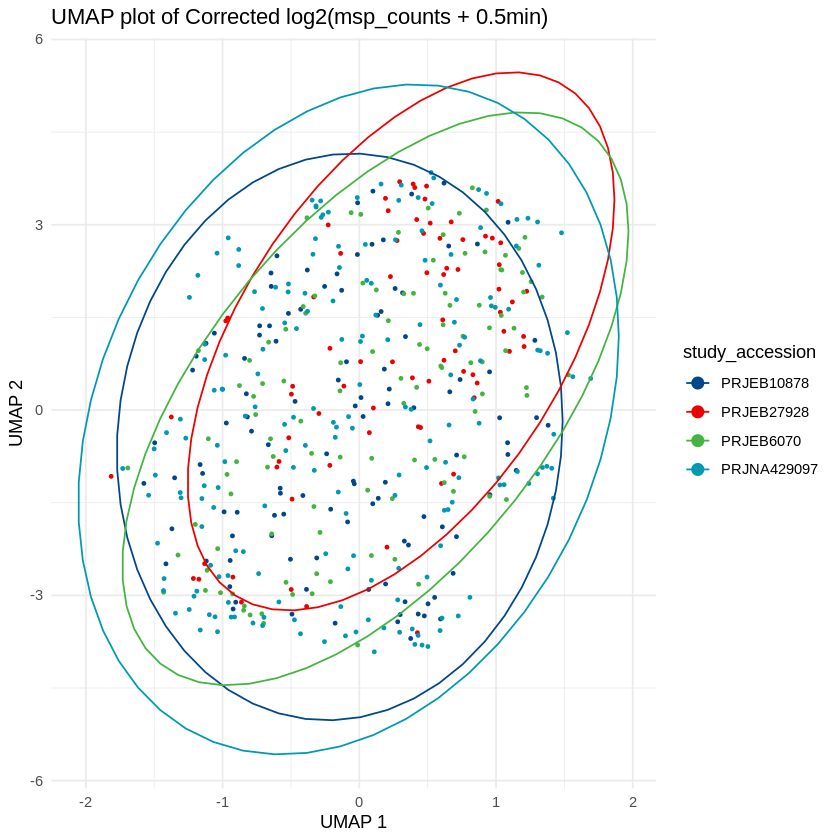

In [40]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_merged_msp, metadata$study_accession, design = design) %>% as.data.frame()


write.table(merged_msp_corrected, file = "/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/results/logmin_four_centers_corrected.tsv", sep = "\t")


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(msp_counts + 0.5min)", color_column = "study_accession")

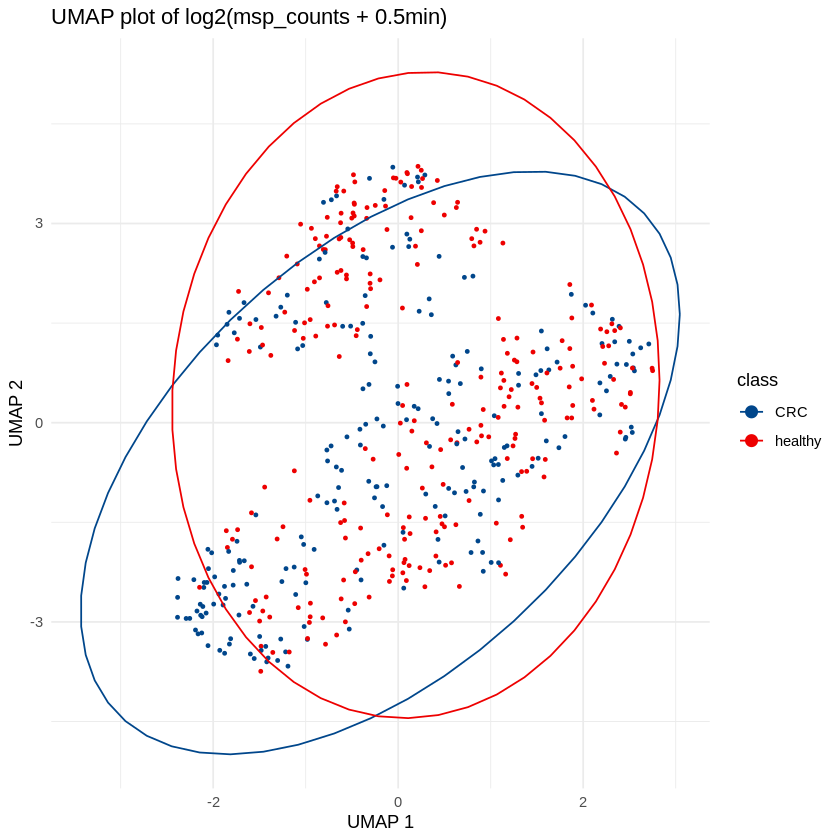

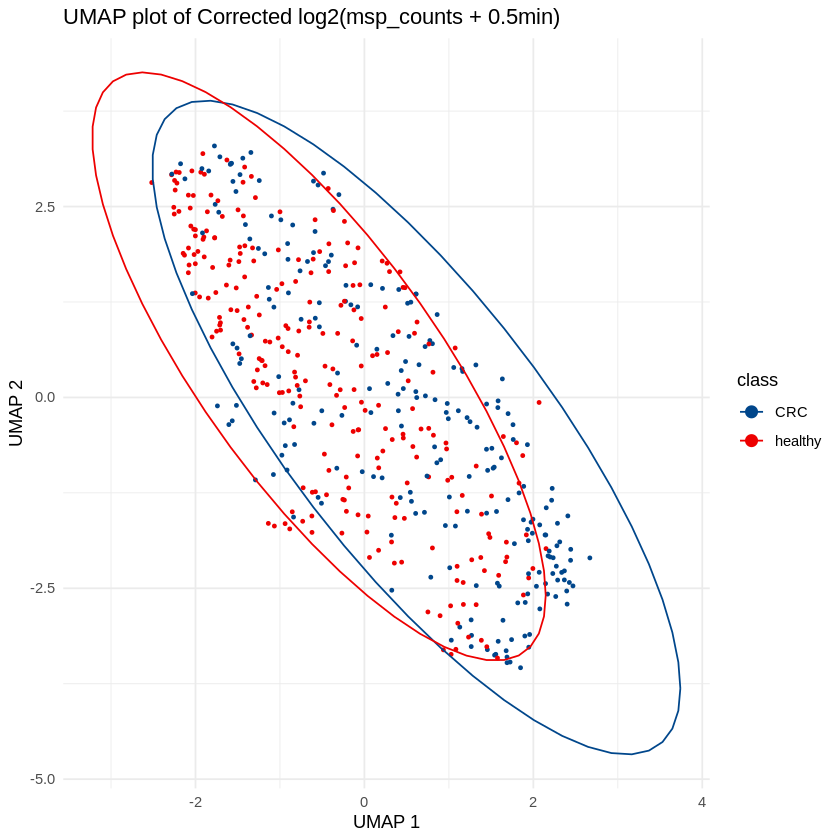

In [33]:


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "class")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(msp_counts + 0.5min)", color_column = "class")

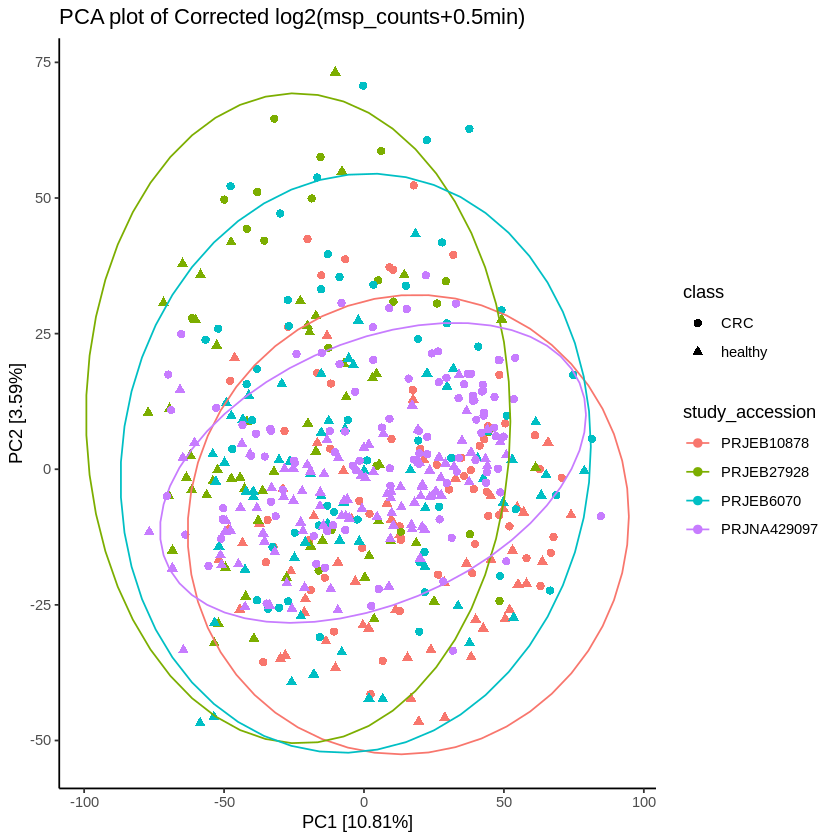

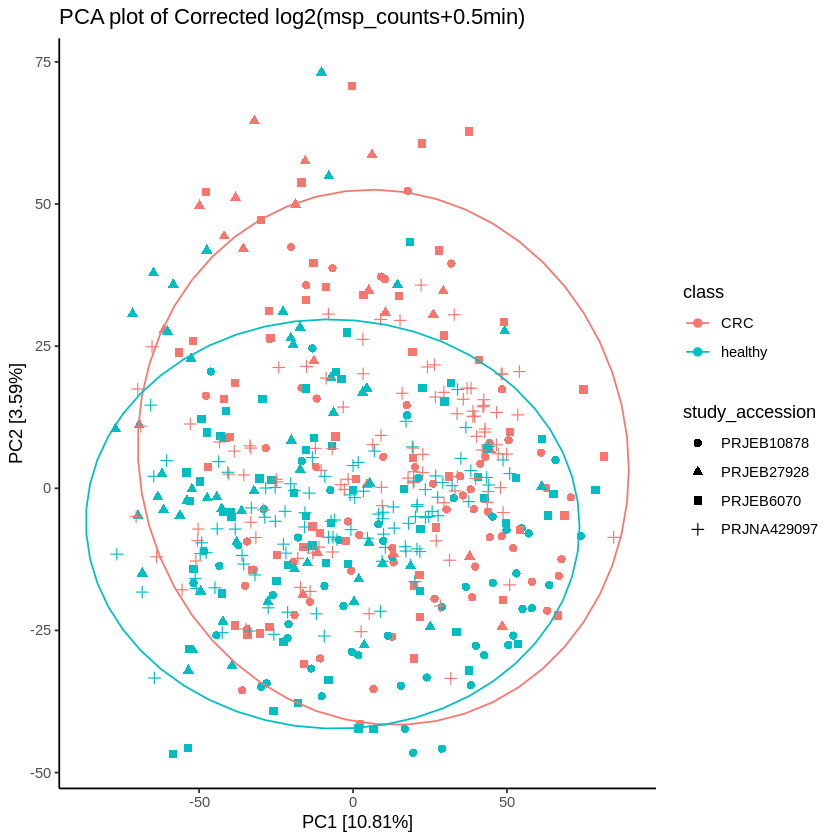

In [39]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

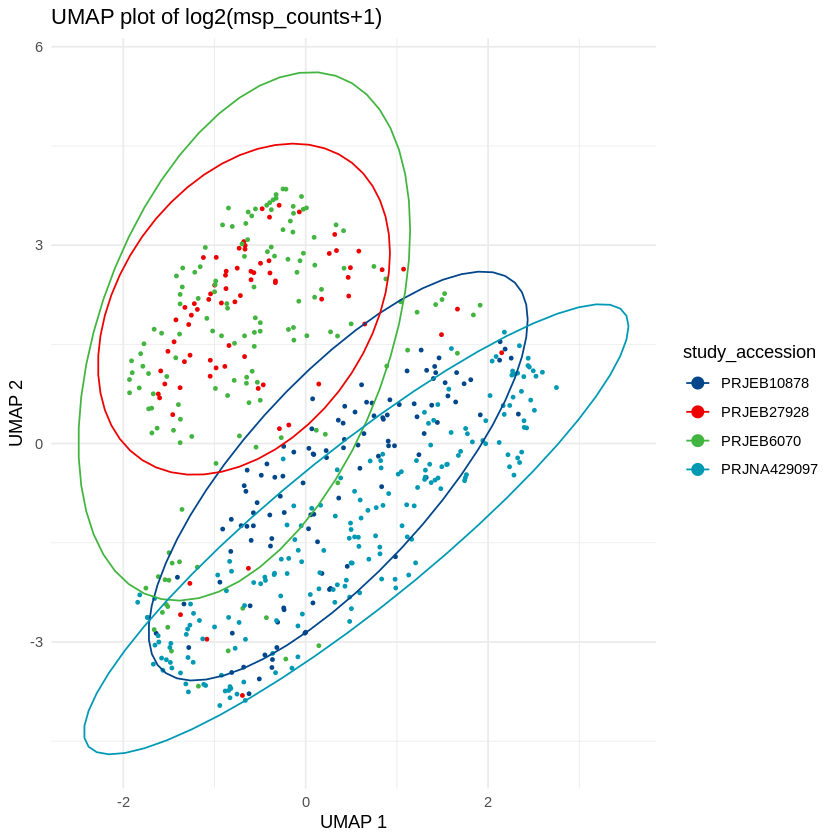

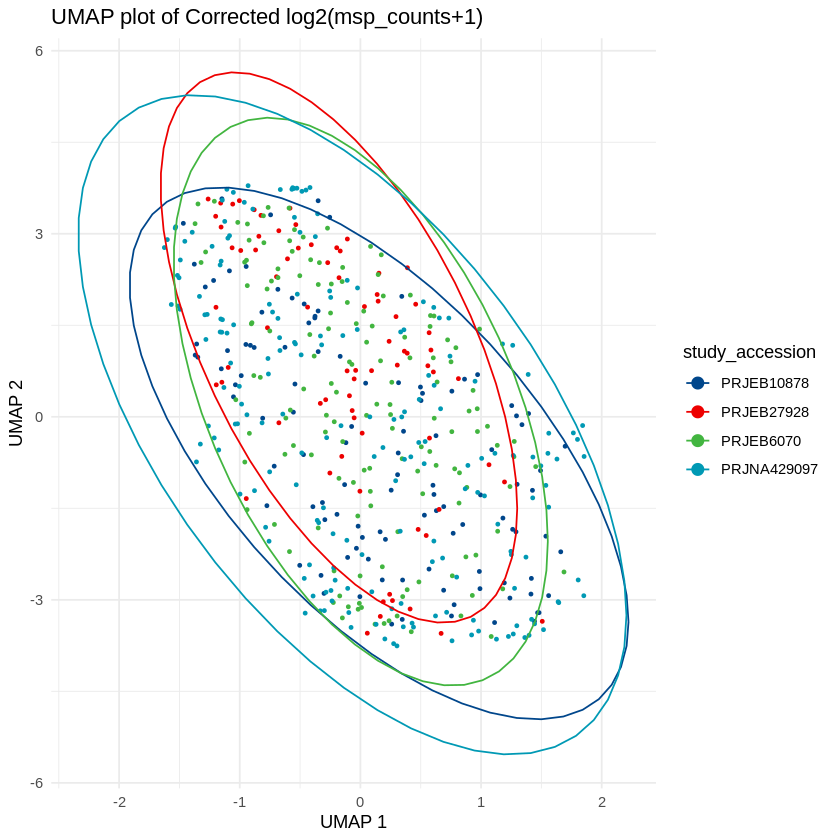

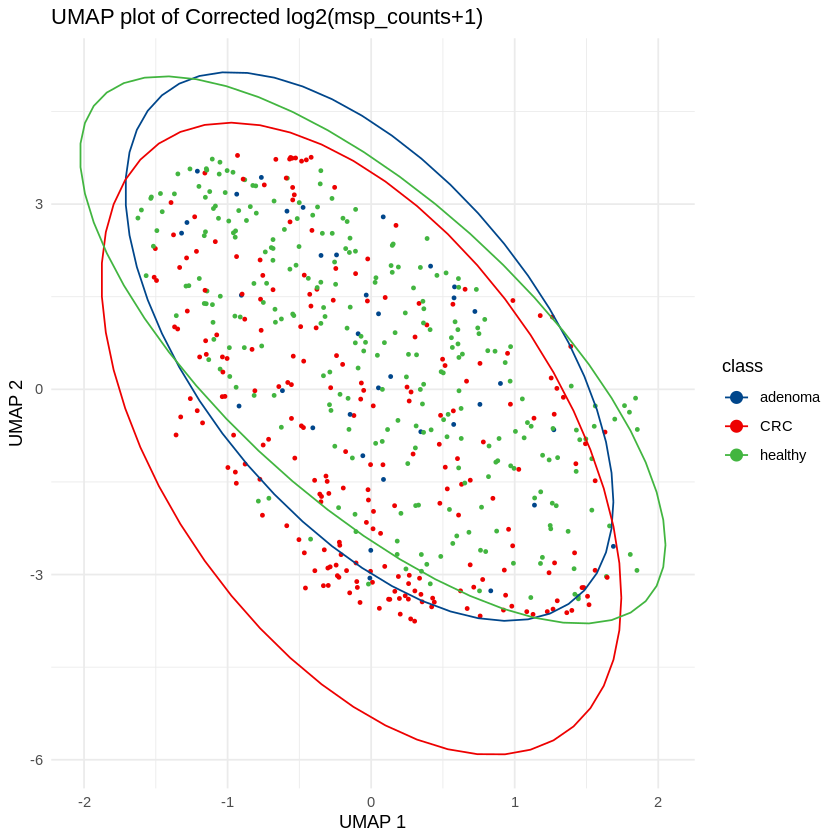

In [ ]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(log2(msp_counts+1), metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(log2(msp_counts+1), metadata, title = "UMAP plot of log2(msp_counts+1)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(msp_counts+1)", color_column = "study_accession")

umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(msp_counts+1)", color_column = "class")

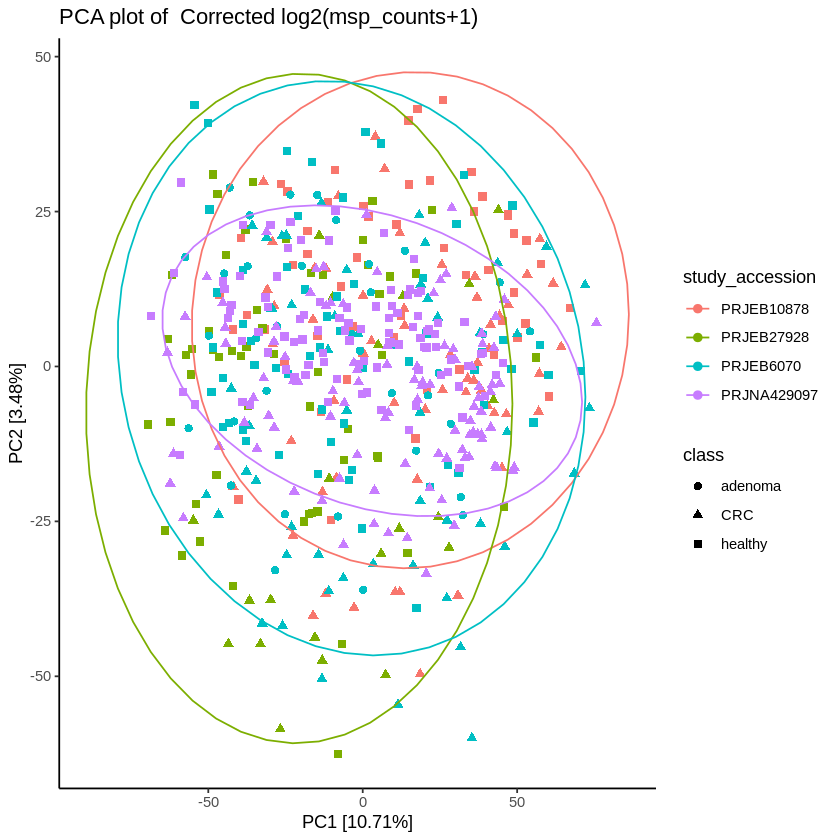

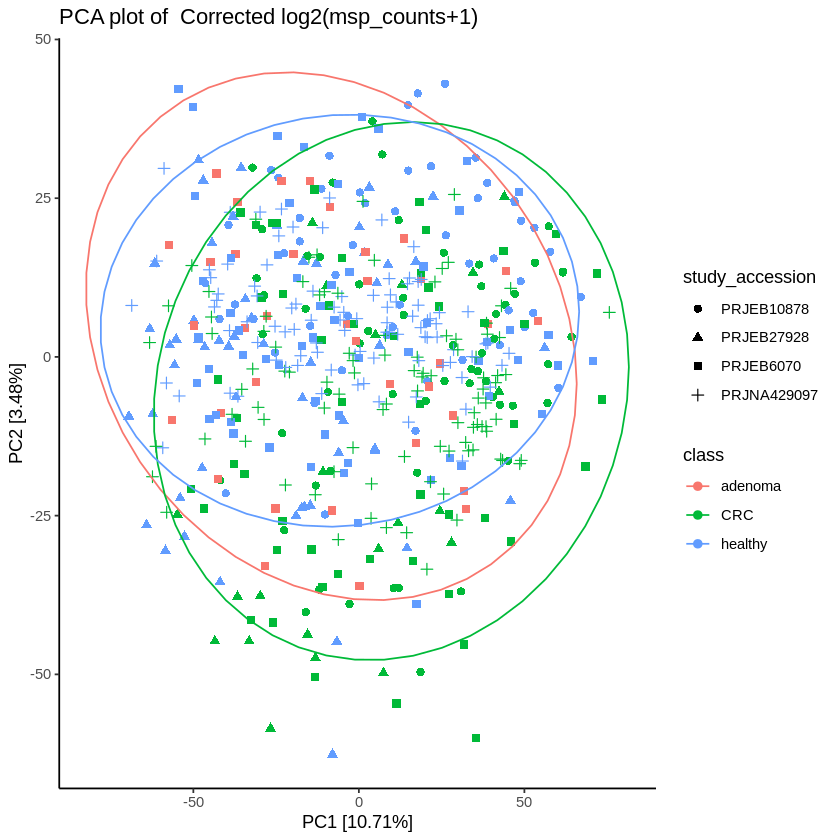

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of  Corrected log2(msp_counts+1)", 
        color_column = "study_accession", shape_column = "class")


pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of  Corrected log2(msp_counts+1)", 
        shape_column = "study_accession", color_column = "class")

# Normalization + correction

In [19]:
all_dge <- DGEList(counts=msp_counts)
all_dge$samples$group <- metadata$class
dds <- DESeqDataSetFromMatrix(countData = all_dge$counts, colData = metadata, design = ~ class)
dds <- estimateSizeFactors(dds)
normalized_counts <- as.data.frame(counts(dds, normalized=TRUE))

In [20]:
logmin_merged_msp <- log2(normalized_counts + min(normalized_counts[normalized_counts > 0])/2)

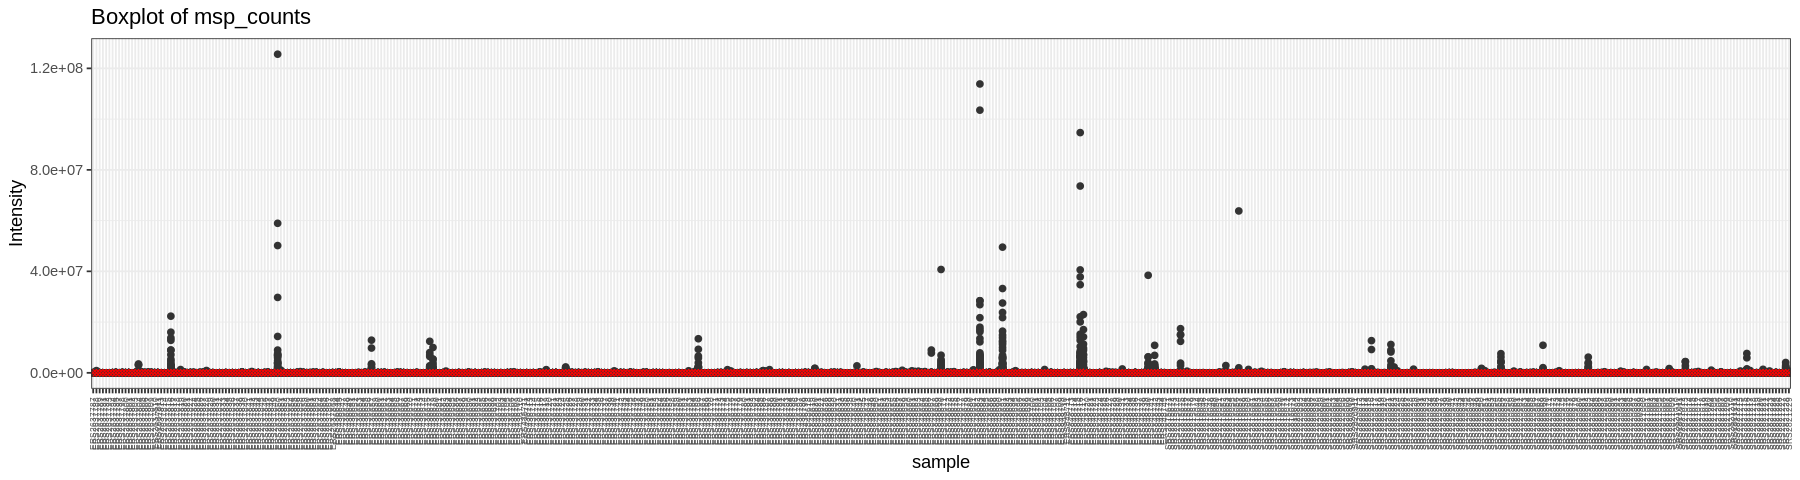

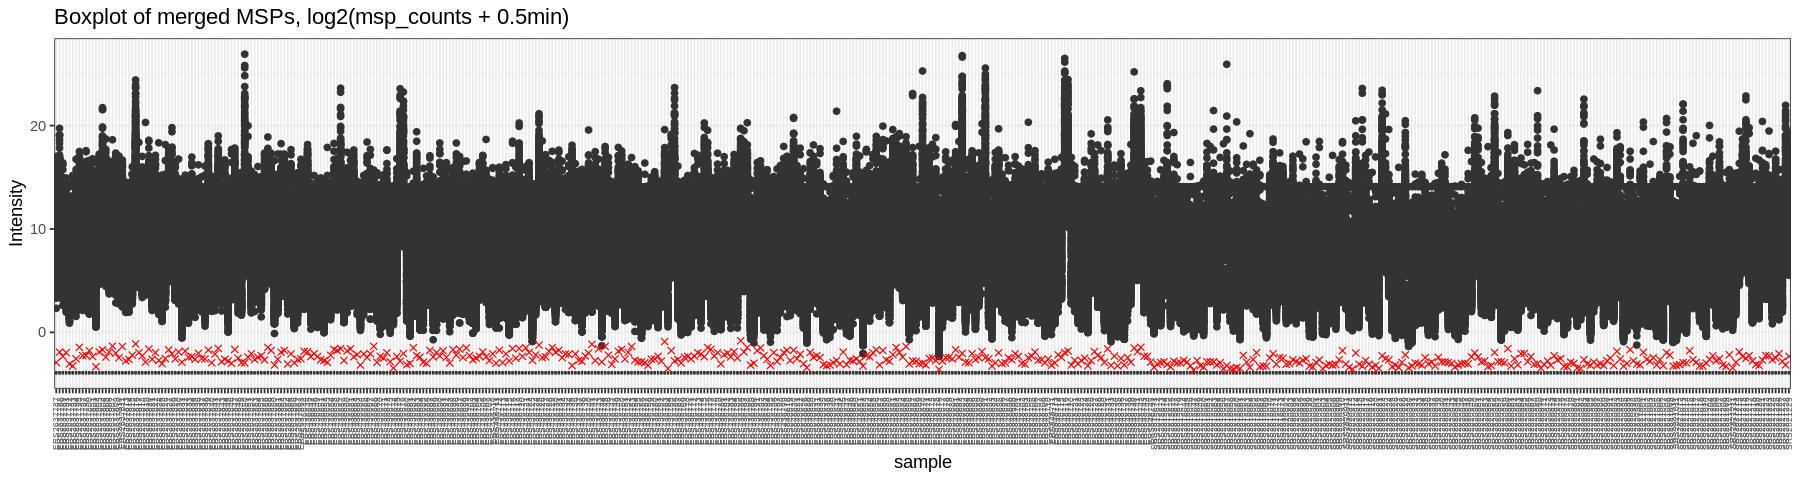

In [21]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(normalized_counts, title = "Boxplot of msp_counts")
boxplot_plot(logmin_merged_msp, title = "Boxplot of merged MSPs, log2(msp_counts + 0.5min)")

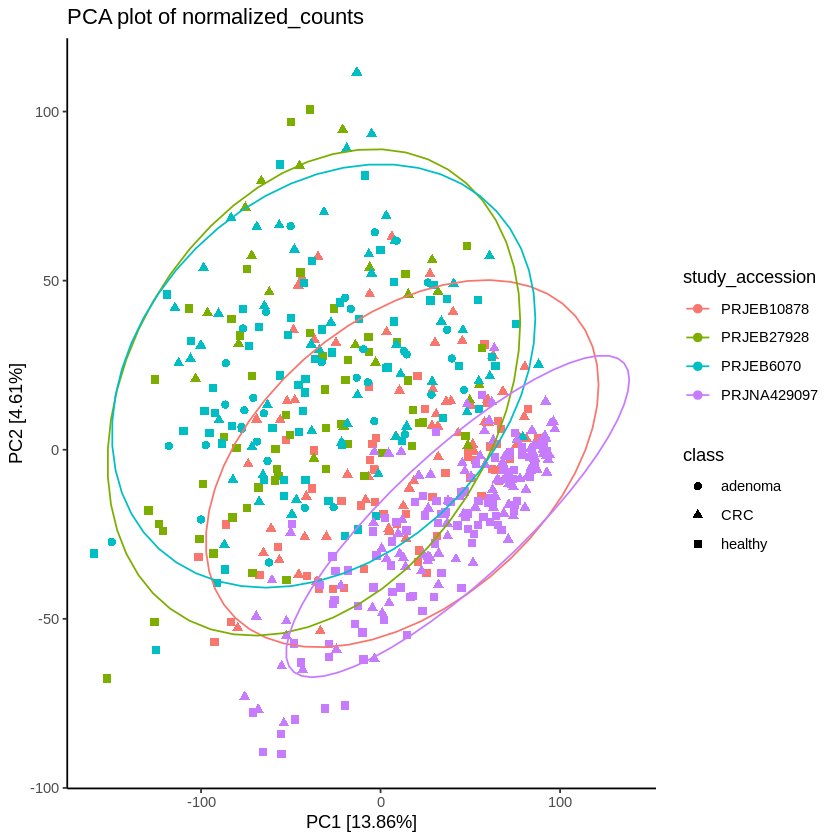

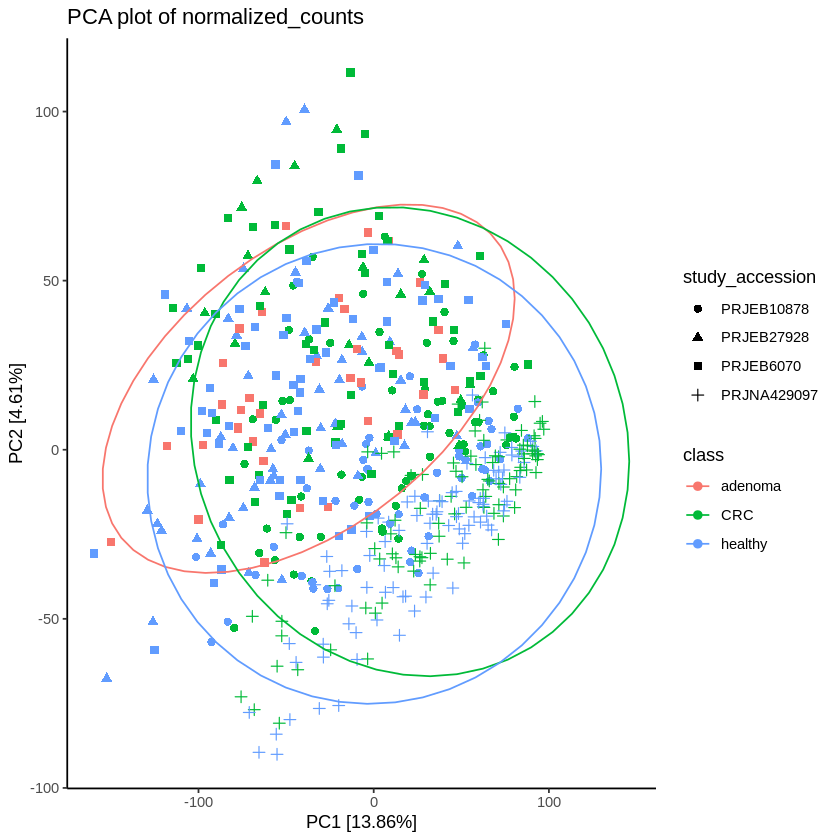

In [22]:
options(repr.plot.width = 7, repr.plot.height = 7)
        
               
pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of normalized_counts", 
        color_column = "study_accession", shape_column = "class")

pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of normalized_counts", 
        shape_column = "study_accession", color_column = "class")

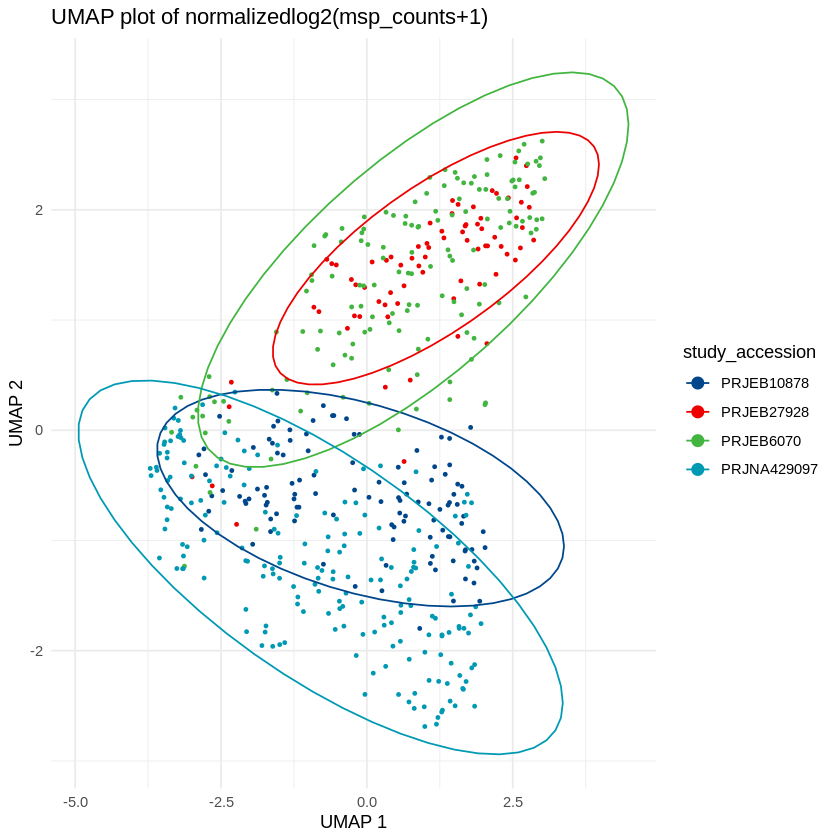

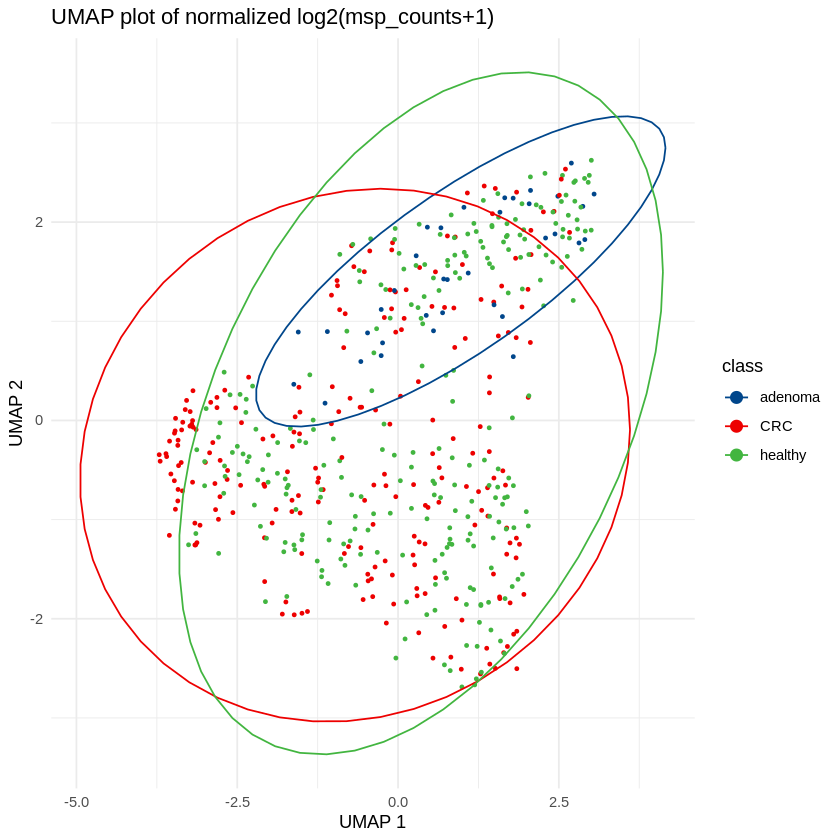

In [23]:
options(repr.plot.width = 7, repr.plot.height = 7)
# umap_plot(log2(normalized_counts+1), metadata, title = "UMAP plot of log2(msp_counts+1)", color_column = "study_accession")
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of normalizedlog2(msp_counts+1)", color_column = "study_accession")
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of normalized log2(msp_counts+1)", color_column = "class")

### correctiom

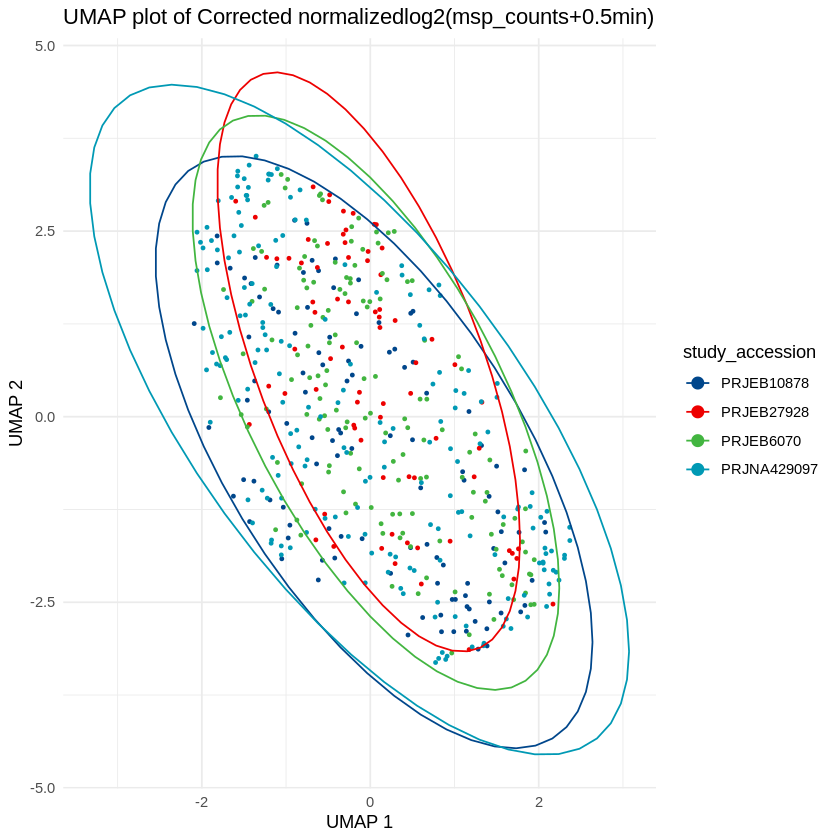

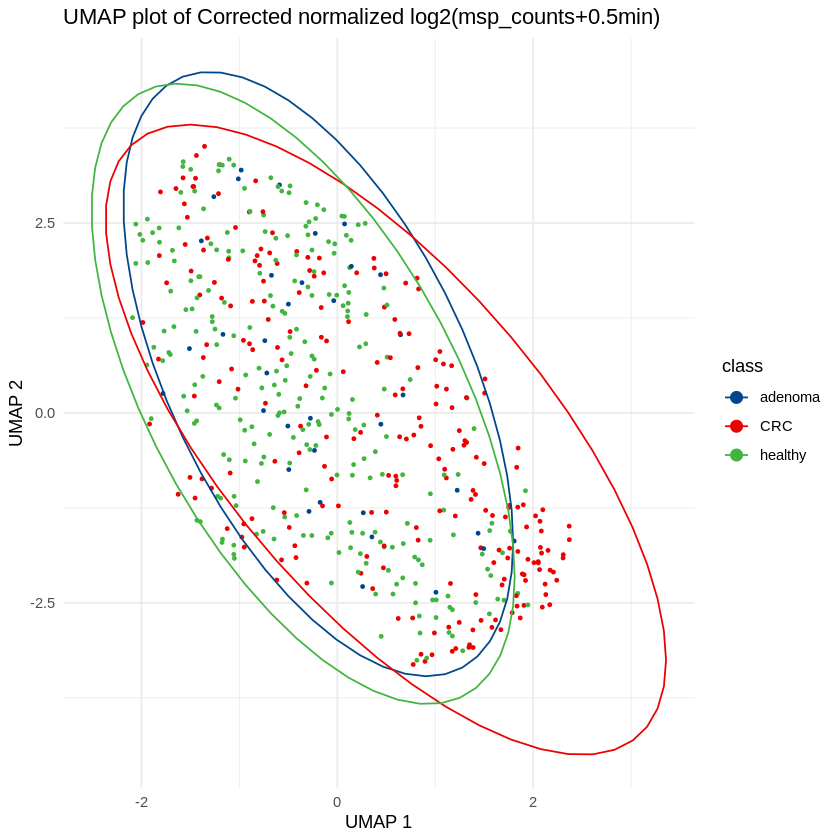

In [24]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_merged_msp, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
# umap_plot(log2(normalized_counts+1), metadata, title = "UMAP plot of log2(msp_counts+1)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected normalizedlog2(msp_counts+0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected normalized log2(msp_counts+0.5min)", color_column = "class")

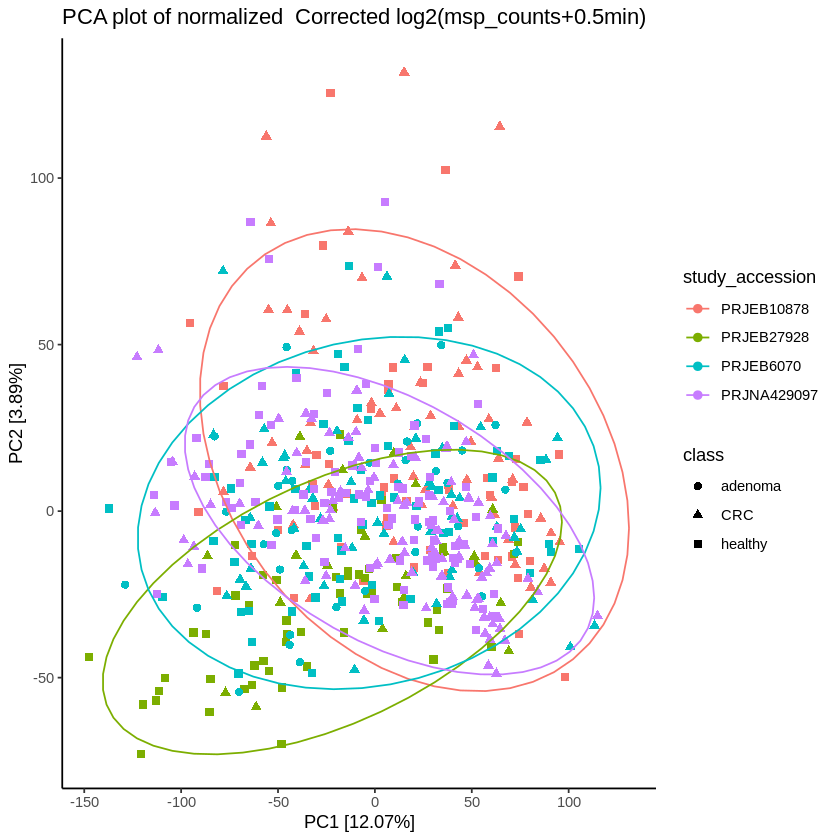

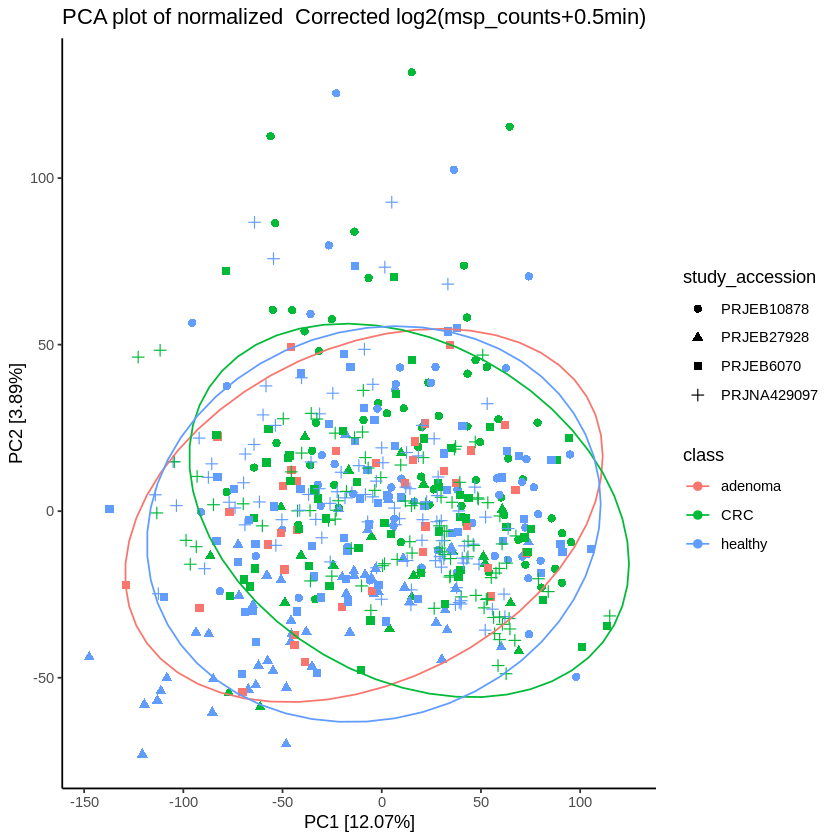

In [25]:
 pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of normalized  Corrected log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")

pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of normalized  Corrected log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

## Filtering normalization correction

In [38]:
more_then_n <- 1

msp_to_keep <- msp_counts %>%
    t() %>% as.data.frame() %>%
    rownames_to_column("sample") %>%
    left_join(select(metadata, c('sample', 'study_accession')), by = "sample") %>%
    column_to_rownames("sample") %>%
    group_by(study_accession) %>%
    summarise(across(everything(), ~sum(.x != 0))) %>%
    column_to_rownames("study_accession") %>%
    # transpose and convert to data frame 
    t() %>% as.data.frame() %>%
    mutate(keep = ifelse(PRJEB27928 > more_then_n & PRJEB6070 > more_then_n & PRJEB10878 > more_then_n & PRJNA429097 > more_then_n, 1, 0)) %>%
    filter(keep == 1) %>%
    rownames_to_column("msp") %>%
    .[,'msp']

dim(msp_counts)
filtered_msp_counts <- msp_counts[rownames_msp %in% msp_to_keep, ]
dim(filtered_msp_counts)



[1] 2537  525

[1] 892 525

In [39]:
all_dge <- DGEList(counts=filtered_msp_counts)
all_dge$samples$group <- metadata$class
dds <- DESeqDataSetFromMatrix(countData = all_dge$counts, colData = metadata, design = ~ class)
dds <- estimateSizeFactors(dds)
normalized_counts <- as.data.frame(counts(dds, normalized=TRUE))

In [40]:
logmin_filtered_msp <- log2(normalized_counts + min(normalized_counts[normalized_counts > 0])/2)

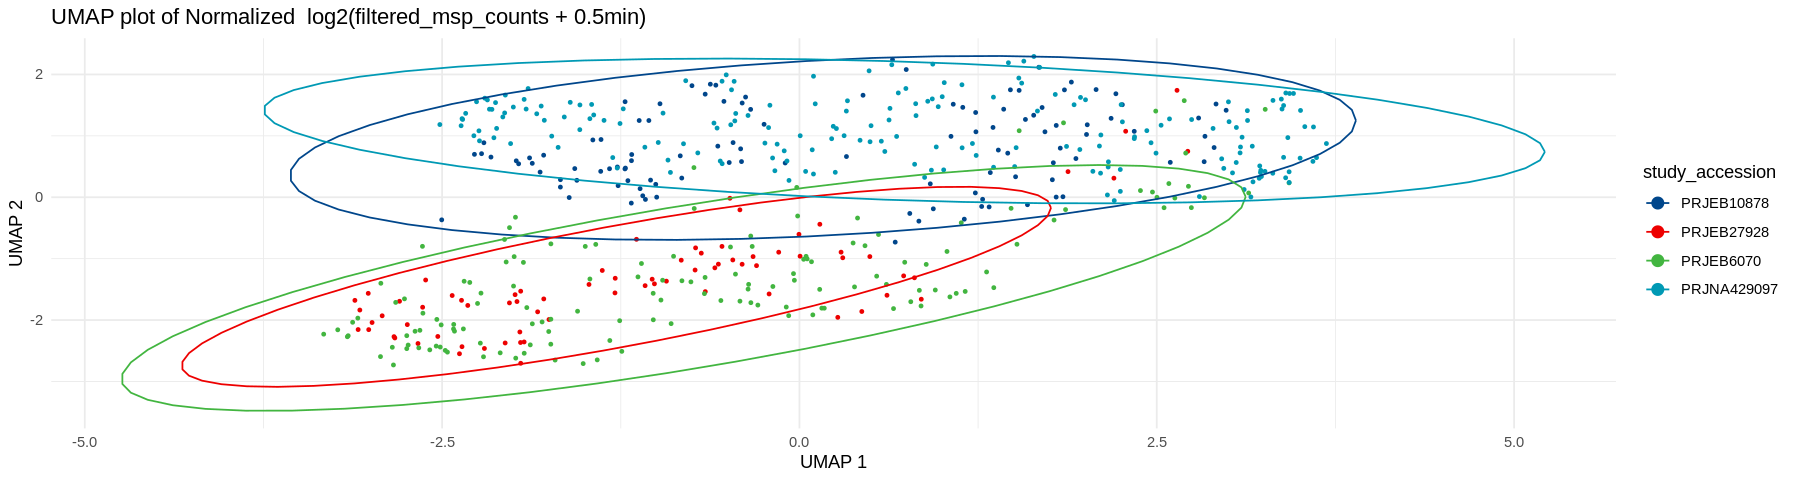

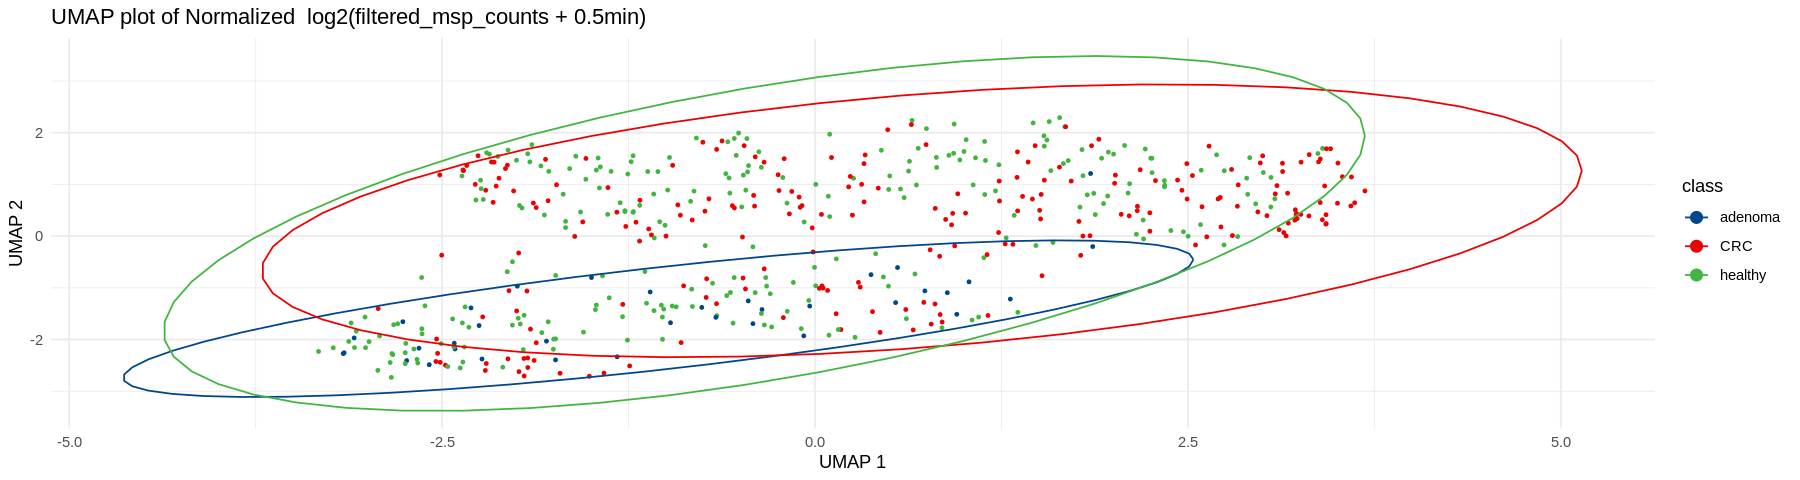

In [41]:
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of Normalized  log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of Normalized  log2(filtered_msp_counts + 0.5min)", color_column = "class")

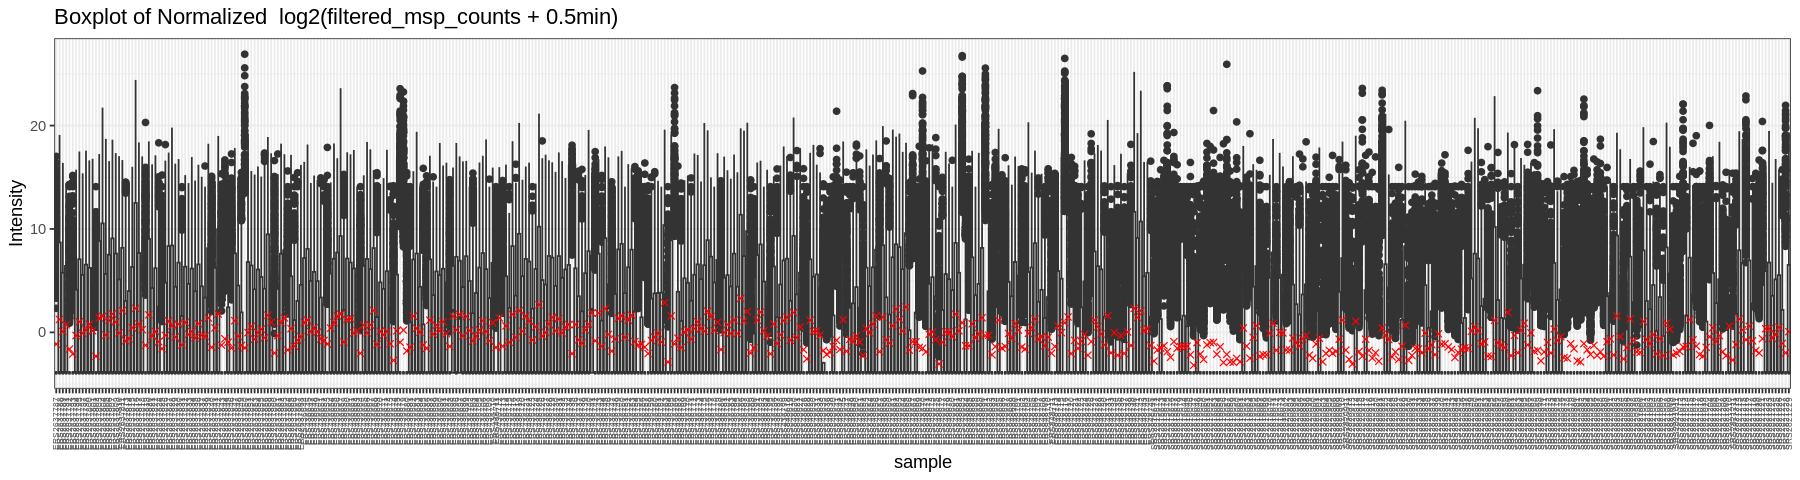

In [42]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(logmin_filtered_msp, title = "Boxplot of Normalized  log2(filtered_msp_counts + 0.5min)")

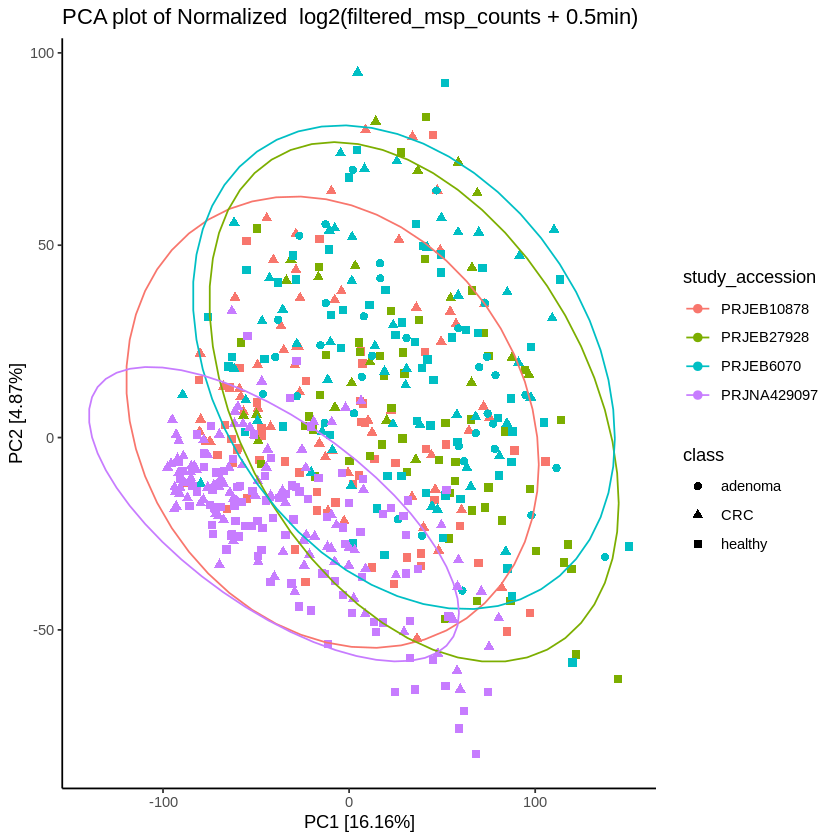

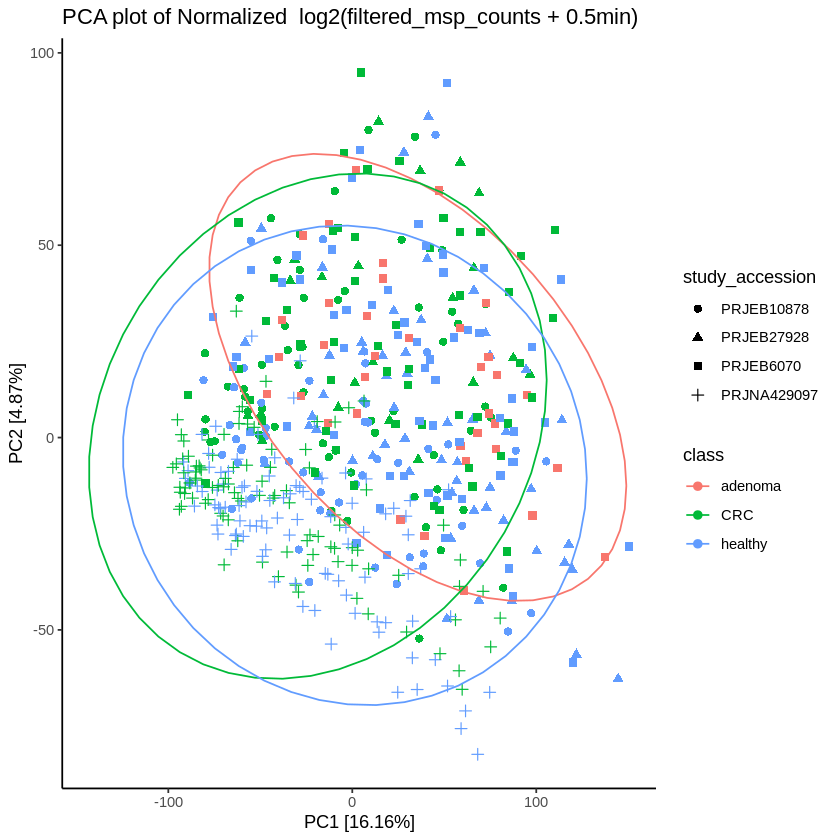

In [43]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(logmin_filtered_msp, metadata, 
        title = "PCA plot of Normalized  log2(filtered_msp_counts + 0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(logmin_filtered_msp, metadata, 
        title = "PCA plot of Normalized  log2(filtered_msp_counts + 0.5min)", 
        shape_column = "study_accession", color_column = "class")

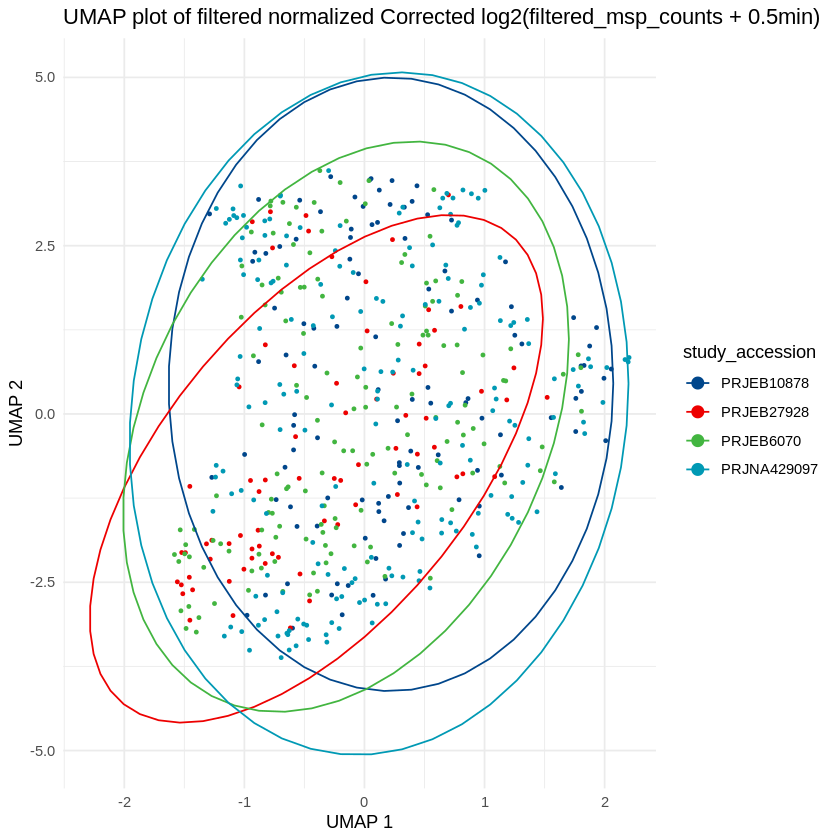

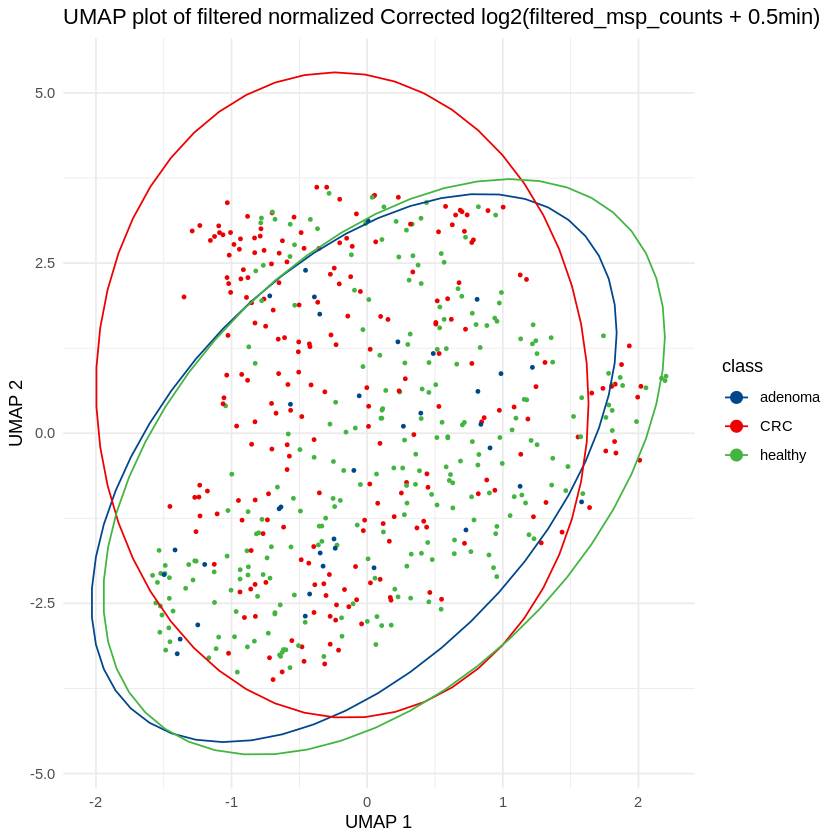

In [44]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_filtered_msp, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of filtered normalized Corrected log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of filtered normalized Corrected log2(filtered_msp_counts + 0.5min)", color_column = "class")

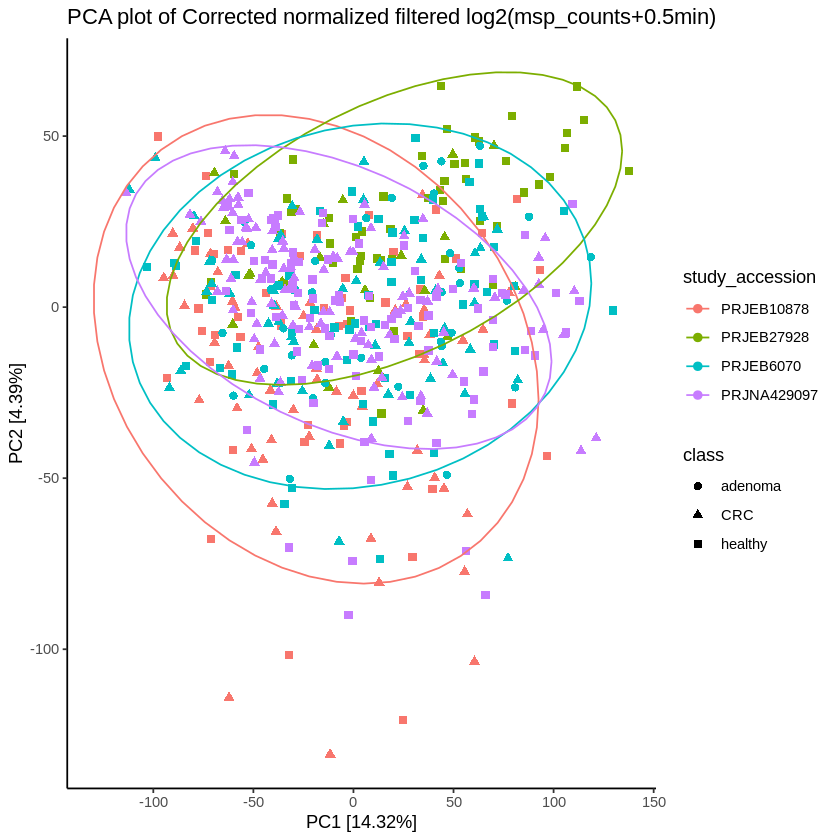

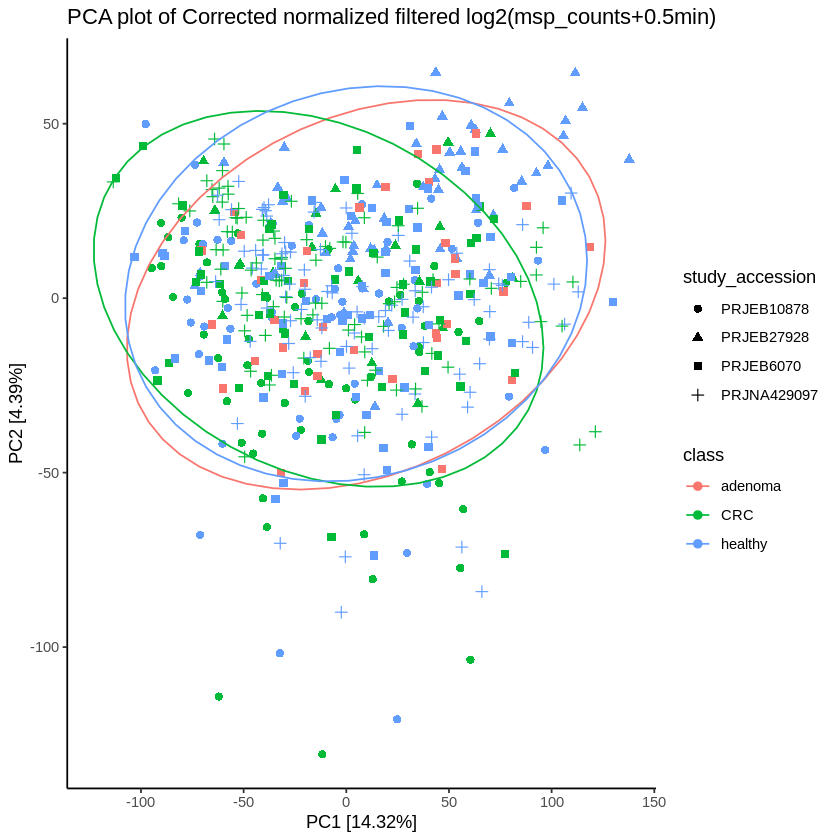

In [45]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected normalized filtered log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected normalized filtered log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

# Remove NA